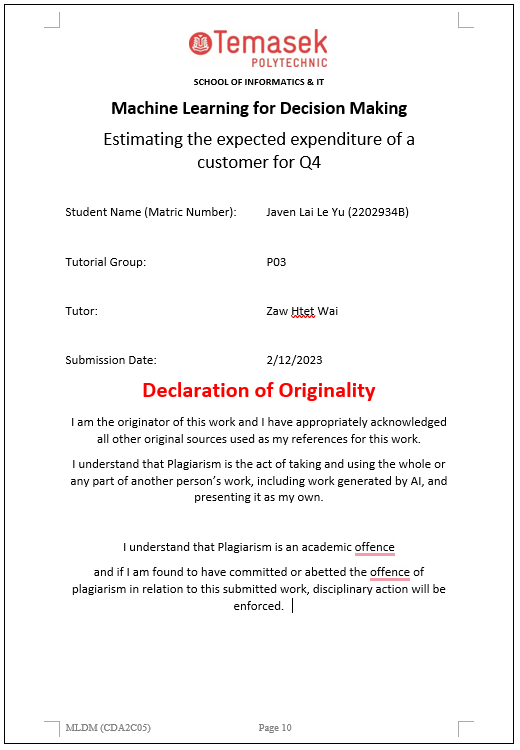

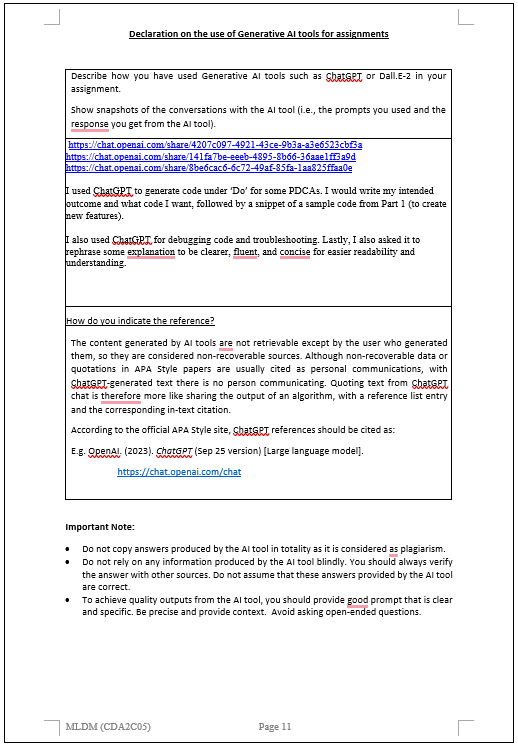

# Solution Part 1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold, ShuffleSplit, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from collections import defaultdict
from category_encoders.target_encoder import TargetEncoder 
SEED = 2202934
plt.rcParams["figure.figsize"] = (16,6)

In [2]:
dataset = pd.read_csv("synthetic_data.csv")

In [3]:
dataset.head()

,Datetime,Product_ID,Category,Quantity,Unit_Price,Customer_ID
0,2022-01-07,10106959,Stationery,9,1.579875,a225207859
1,2022-01-09,90097406,Sports,4,196.253377,a225207859
2,2022-01-10,10010465,Electronics,1,825.374291,a225207859
3,2022-01-14,10010510,Electronics,2,325.965035,a225207859
4,2022-01-16,40049430,Books,1,22.601919,a225207859


In [4]:
dataset.tail()

,Datetime,Product_ID,Category,Quantity,Unit_Price,Customer_ID
331659,2022-12-18,20026116,Groceries,5,5.378162,c891387366
331660,2022-12-23,10018925,Electronics,1,1193.828519,c891387366
331661,2022-12-27,20022820,Groceries,3,5.175492,c891387366
331662,2022-12-27,40042985,Books,2,38.598536,c891387366
331663,2022-12-31,20025163,Groceries,3,5.397744,c891387366


In [5]:
dataset.columns = dataset.columns.str.lower()

In [6]:
#create new column "expense" with unit_price*quantity
dataset["expense"] = dataset["unit_price"]*dataset["quantity"]

In [7]:
#read event_time as datetime
dataset['datetime'] = pd.to_datetime(dataset['datetime'], format='%Y-%m-%d')

In [8]:
dataset['datetime'] = pd.to_datetime(dataset['datetime'])
dataset['year'] = dataset['datetime'].dt.year
dataset['quarter'] = dataset['datetime'].dt.to_period("Q")

# Calculate the 'expense' column
dataset['expense'] = dataset['unit_price'] * dataset['quantity']

# Initialize an empty DataFrame to store transformed dataset
df = pd.DataFrame()

# Loop through each quarter in 2022 to perform aggregations
for quarter in dataset[dataset['year'] == 2022]['quarter'].unique():
    temp_df = dataset[(dataset['quarter'] == quarter) & (dataset['year'] == 2022)].copy()

    grouped = temp_df.groupby('customer_id').agg(
        total_items=('product_id', 'count'),
        total_expense=('expense', 'sum'),
    ).reset_index()
    
    # Rename columns to indicate the quarter
    grouped.columns = [f"{col}_{quarter}" if col != 'customer_id' else col for col in grouped.columns]
    
    # Merge this quarter's data into the final DataFrame
    if df.empty:
        df = grouped
    else:
        df = pd.merge(df, grouped, on='customer_id', how='outer')
        
# Create a df without features beyond 2022Q3 except for Target
final_df = df.copy()

# Identify columns related to quarters beyond 2022Q3 excluding Target
columns_to_drop = [col for col in final_df.columns if '2022Q4' in col and col != 'total_expense_2022Q4']

# Drop the identified columns
final_df = final_df.drop(columns=columns_to_drop)
        
# Show the resulting DataFrame
final_df.head().transpose()

,0,1,2,3,4
customer_id,a001192674,a001713895,a002096298,a002306341,a003157865
total_items_2022Q1,29,30,30,24,20
total_expense_2022Q1,6069.341932,6888.929143,6616.97386,4480.895657,6120.452162
total_items_2022Q2,28,24,30,23,29
total_expense_2022Q2,4991.923424,4629.708661,6825.834052,7869.628291,7768.157905
total_items_2022Q3,27,30,27,22,23
total_expense_2022Q3,5642.684311,6486.449628,5724.875642,4197.345032,5734.627161
total_expense_2022Q4,9901.777797,5642.928052,4643.72761,6567.149577,9050.380186


In [9]:
TARGET_COLUMN = 'total_expense_2022Q4'

# Drop Q4-related features and 'customer_id'
drop_columns = [col for col in final_df.columns if '2022Q4' in col or col == 'customer_id']
X = final_df.drop(drop_columns + [TARGET_COLUMN], axis=1)
y =  final_df[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)


model = DecisionTreeRegressor(random_state=SEED)
# Fit the model
model.fit(X_train, y_train)
# Predict on the test set
y_pred = model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

In [10]:
# Predict on the training set
y_pred_train = model.predict(X_train)

# Evaluate on the training set
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Print evaluation metrics
print(f"Mean Absolute Percentage Error on Train Set: {mape_train:.2f}")
print(f"R-squared on Train Set: {r2_train:.2f}")

Mean Absolute Percentage Error on Train Set: 0.00
R-squared on Train Set: 1.00


In [11]:
# Evaluate on the test set
mape_test = mean_absolute_percentage_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Percentage Error on Test Set: {mape_test:.2f}")
print(f"R-squared on Test Set: {r2_test:.2f}")

Mean Absolute Percentage Error on Test Set: 0.40
R-squared on Test Set: 0.64


# Solution Part 2

### For storing model performance

In [12]:
# setup df to contain all scores across various "engineering" or PDCA cycles, for easy reading
results = pd.DataFrame(columns=['Model', 'MAPE Test', 'R2 Test', 'MAPE Train', 'R2 Train', 'Parameters'])

In [13]:
def store_model(model_name, mape_test, r2_test, mape_train, r2_train, dataset="final_df", params=None):
    global results
    
    # Store the model and metrics in the DataFrame
    new_row = pd.DataFrame({
        'Model': [model_name],
        'MAPE Test': [mape_test],
        'R2 Test': [r2_test],
        'MAPE Train': [mape_train],
        'R2 Train': [r2_train],
        'Dataset': [dataset],
        'Parameters': [params]
    })
    
    results = pd.concat([results, new_row], ignore_index=True)
    display(results)

In [14]:
store_model('Benchmark DTR', mape_test, r2_test, mape_train, r2_train)

,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters,Dataset
0,Benchmark DTR,0.403236,0.63825,0.0,1.0,None,final_df


### Evaluate Model Performance

In [15]:
def evaluate_model(model, X, y, type):
    """
    Evaluate the performance of a regression model on the given dataset.

    Parameters:
    - model: The regression model to evaluate.
    - X: The feature matrix.
    - y: The target variable.
    - type: Train or Test

    Returns:
    - mape: Mean Absolute Percentage Error
    - r2: R-squared
    """
    # Predict on the given dataset
    y_pred = model.predict(X)

    # Calculate metrics
    mape = mean_absolute_percentage_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # print metrics
    print(f"Mean Absolute Percentage Error on {type} Set: {mape:.2f}")
    print(f"R-squared on {type} Set: {r2:.2f}")

    return mape, r2

### Model Comparer
Compare which model produces more accurate predictions with smaller residual. Contains visualization.

In [16]:
def model_comparer(model1, model2, df1, df2, sample_size=500, random_state=SEED, target=TARGET_COLUMN, drop=[]):
    """
    Compares model performance using residuals

    Parameters:
    - model 1
    - model 2
    - dataset for model 1
    - dataset for model 2
    - number of samples for viz
    - randomstate
    - target column
    - array containing columns to drop from datasets

    Returns:
    - Graph of residuals for each model
    - Best performing model based on smallest average residual
    """
    
    # SPLIT TO TRAIN TEST FOR MODEL1 AND MODEL2 DATASETS
    X1_train, X1_test, y1_train, y1_test = train_test_split(df1.drop([TARGET_COLUMN]+drop, axis=1), df1[TARGET_COLUMN],
                                                            test_size=0.2, random_state=random_state)
    
    X2_train, X2_test, y2_train, y2_test = train_test_split(df2.drop([TARGET_COLUMN]+drop, axis=1), df2[TARGET_COLUMN],
                                                            test_size=0.2, random_state=random_state)

    # INIT VARIABLE
    models = [model1, model2]
    labels = ['Model 1', 'Model 2']
    colors = ['red', 'teal']
    
    fig, ax = plt.subplots(figsize=(16, 6))   # Create a figure and axis for the residual plot

    stats = {}                                # Dictionary to store statistics for each model

    for i, (model, label, color, X_test, y_test) in enumerate(zip(models, labels, colors, [X1_test, X2_test], [y1_test, y2_test])):
        y_pred = model.predict(X_test)       # Make predictions using the current model

        # Limit the dataset to a specified sample size and reset the index to make a smooth residual plot that starts from 0
        y_sample = y_test.iloc[:sample_size].reset_index(drop=True)
        y_pred_sample = y_pred[:sample_size]

        residuals = y_sample - y_pred_sample  # Calculate residuals for the current model
        stats[label] = {
            'Q1 (25th percentile)': np.percentile(residuals, 25),
            'Q3 (75th percentile)': np.percentile(residuals, 75)
        }

        # Plot mean and percentiles of the current model
        for stat_name, value in stats[label].items():
            ax.axhline(value, color=color, linestyle='dashed', linewidth=2, label=f'{label} {stat_name}')

        ax.plot(residuals, color, label=label, alpha=0.6)

    plt.title(f'Residual Plot of {X1_train.columns} Vs {X2_train.columns}')
    ax.legend()
    plt.show()

    # Compare IQRs to determine the model with the smallest IQR range
    iqr_1 = stats[labels[0]]['Q3 (75th percentile)'] - stats[labels[0]]['Q1 (25th percentile)']
    iqr_2 = stats[labels[1]]['Q3 (75th percentile)'] - stats[labels[1]]['Q1 (25th percentile)']

    if iqr_1 < iqr_2:
        return f"Model 1 {model1} with {list(X1_train.columns)} has the smallest IQR range."
    elif iqr_2 < iqr_1:
        return f"Model 2 {model2} with {list(X2_train.columns)} has the smallest IQR range."
    else:
        return f"Both Models have the same IQR range."

### Hyperparameter tuning

In [17]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [None, 5, 10, 15],             # Maximum depth of the tree
    'max_features': ['auto', 'sqrt', 'log2'],   # Maximum number of features considered for splitting a node
    'max_leaf_nodes': [None, 10, 20, 30],       # Maximum number of leaf nodes in the tree
}

In [18]:
def param_tuning(model, X_train, y_train): 
    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print(f"Best Hyperparameters: {best_params}\n")
    return best_params

### Model builder and Performance checker

In [19]:
# automate model building + performing checking + storing record process
def check_performance(name, df, exclude=None, target=TARGET_COLUMN, params='', SEED=SEED):
    
    # train_test_split PREDICTORS AND TARGET
    if exclude:
        X = df.drop(columns=[target, exclude])
        
    else:
        X = df.drop(columns=[target])
        
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED) # holdout strategy
    
    # Find best params using grid search
    model = DecisionTreeRegressor(random_state=SEED)    # baseline
    best_params = param_tuning(model, X_train, y_train)
    
    # Rebuild Decision Tree Regressor with best parameters
    model = DecisionTreeRegressor(**best_params, random_state=SEED)
    model.fit(X_train, y_train)

    # Print feature importances
    feature_importances = list(zip(X.columns, model.feature_importances_))
    feature_importances_df = pd.DataFrame(feature_importances, columns=['Feature', 'Importance'])
    feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
    print(feature_importances_df)
    
    print('\nTraining performance')
    mape_train, r2_train = evaluate_model(model, X_train, y_train, 'Train')
    
    print('\nTesting performance')
    mape_test, r2_test = evaluate_model(model, X_test, y_test, 'Test')
    
    store_model(name, mape_test, r2_test, mape_train, r2_train, dataset=list(X.columns), params=best_params)
    return model

In [20]:
model = check_performance('Pruned Benchmark DTR', final_df, exclude='customer_id', 
                          target=TARGET_COLUMN, SEED=SEED)

Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 10}

                Feature  Importance
2    total_items_2022Q2    0.989440
3  total_expense_2022Q2    0.005908
1  total_expense_2022Q1    0.001951
5  total_expense_2022Q3    0.001729
4    total_items_2022Q3    0.000972
0    total_items_2022Q1    0.000000

Training performance
Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.30
R-squared on Test Set: 0.82


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters,Dataset
0,Benchmark DTR,0.403236,0.63825,0.0,1.0,None,final_df
1,Pruned Benchmark DTR,0.304871,0.820964,0.274062,0.841938,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_2022Q1, total_expense_2022Q1, tot..."


Disparity in training and testing performance indicates overfitting where the model is not well-generalized and unable to perform well with unseen data. Hyperparameter tuning restricts the DTR from overgrowing, thereby eliminating likelyhood of overfitting.

In [21]:
# Calculate the correlation matrix
corr_mat = final_df.corr()

# Display the correlation matrix with a blue color gradient
corr_mat.style.background_gradient(cmap='Blues')

,total_items_2022Q1,total_expense_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_items_2022Q3,total_expense_2022Q3,total_expense_2022Q4
total_items_2022Q1,1.000000,0.922950,0.869373,0.851799,0.872623,0.850162,0.842149
total_expense_2022Q1,0.922950,1.000000,0.841242,0.847217,0.850095,0.848361,0.842224
total_items_2022Q2,0.869373,0.841242,1.000000,0.922085,0.875199,0.853113,0.836911
total_expense_2022Q2,0.851799,0.847217,0.922085,1.000000,0.858898,0.858018,0.845346
total_items_2022Q3,0.872623,0.850095,0.875199,0.858898,1.000000,0.926780,0.836551
total_expense_2022Q3,0.850162,0.848361,0.853113,0.858018,0.926780,1.000000,0.842222
total_expense_2022Q4,0.842149,0.842224,0.836911,0.845346,0.836551,0.842222,1.000000


- Multicollinearity between total_items and total_expense.
- total_items and total_expense across all quarters are highly correlated.

## PDCA 1: Interpretability and Usability of Model

### Plan:
The model performance may be decent but the expenses values are incomprehensible and doesnt resemble conventional retail prices where prices do not go below cents. 
> Hence, I will round-off expenses to 2 d.p. to match conventional understanding.

Next, the business may have insufficient time to report findings to seek approval from superiors and implement business strategies in time for Q4 as the model can only be used after Q3 when all the data is collated. 
> Removing Q3 data is beneficial in aiding usability as it gives time for user to collate the data, use the model, formulate data-driven decisions and strategies, get approval for plans, and implement the strategies.

Additionally, there is high collinearity between expenses and total items between the quarters, suggesting they are closely related across the quarters and shouldn't be seperated.
> Thus, I will combine the total expenses and total items for each quarter so that the model becomes interpretable; provide overview interpretation of how total expenses or items for Q1-Q2 influence predictions instead of interpreting how expenses for Q1 and expenses for Q2 influence Q4's expenses individually.

References:
- https://www.cascade.app/blog/how-to-formulate-a-strategy
- https://www.indeed.com/career-advice/career-development/quarterly-plan

### Do:

In [22]:
df_1 = final_df.copy()     # save point

Round to 2d.p.

In [23]:
df_1 = df_1.round(2) # round to 2d.p.

df_1.head()

,customer_id,total_items_2022Q1,total_expense_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_items_2022Q3,total_expense_2022Q3,total_expense_2022Q4
0,a001192674,29,6069.34,28,4991.92,27,5642.68,9901.78
1,a001713895,30,6888.93,24,4629.71,30,6486.45,5642.93
2,a002096298,30,6616.97,30,6825.83,27,5724.88,4643.73
3,a002306341,24,4480.90,23,7869.63,22,4197.35,6567.15
4,a003157865,20,6120.45,29,7768.16,23,5734.63,9050.38


Dropping Q3 features

In [24]:
cols_to_drop = [col for col in df_1.columns if 'Q3' in col] # list all Q3 columns
df_1 = df_1.drop(columns=cols_to_drop)                      # drop Q3 cols

df_1.head()

,customer_id,total_items_2022Q1,total_expense_2022Q1,total_items_2022Q2,total_expense_2022Q2,total_expense_2022Q4
0,a001192674,29,6069.34,28,4991.92,9901.78
1,a001713895,30,6888.93,24,4629.71,5642.93
2,a002096298,30,6616.97,30,6825.83,4643.73
3,a002306341,24,4480.90,23,7869.63,6567.15
4,a003157865,20,6120.45,29,7768.16,9050.38


Combining total_items and total_expense across Q1-Q2

In [25]:
# Summing total_items and total_expense across Q1 and Q2
df_1['total_items_Q1_Q2'] = df_1['total_items_2022Q1'] + df_1['total_items_2022Q2']
df_1['total_expense_Q1_Q2'] = df_1['total_expense_2022Q1'] + df_1['total_expense_2022Q2']

# Drop the individual Q1 and Q2 columns
df_1 = df_1.drop(columns=['total_items_2022Q1', 'total_expense_2022Q1', 
                          'total_items_2022Q2', 'total_expense_2022Q2'])

df_1.head()

,customer_id,total_expense_2022Q4,total_items_Q1_Q2,total_expense_Q1_Q2
0,a001192674,9901.78,57,11061.26
1,a001713895,5642.93,54,11518.64
2,a002096298,4643.73,60,13442.80
3,a002306341,6567.15,47,12350.53
4,a003157865,9050.38,49,13888.61


### Check:

In [26]:
# build new DTR with new features
model_1 = check_performance('PDCA 1 (dropping Q3 + combine across quarters)', df_1, exclude='customer_id')

Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 10}

               Feature  Importance
1  total_expense_Q1_Q2    0.997885
0    total_items_Q1_Q2    0.002115

Training performance
Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.30
R-squared on Test Set: 0.82


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters,Dataset
0,Benchmark DTR,0.403236,0.63825,0.0,1.0,None,final_df
1,Pruned Benchmark DTR,0.304871,0.820964,0.274062,0.841938,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_2022Q1, total_expense_2022Q1, tot..."
2,PDCA 1 (dropping Q3 + combine across quarters),0.30398,0.81998,0.27044,0.839315,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_Q1_Q2, total_expense_Q1_Q2]"


Negligible performance difference. Insignificant increase in accuracy (lower MAPE) and decrease in explainability of model (lower R2).

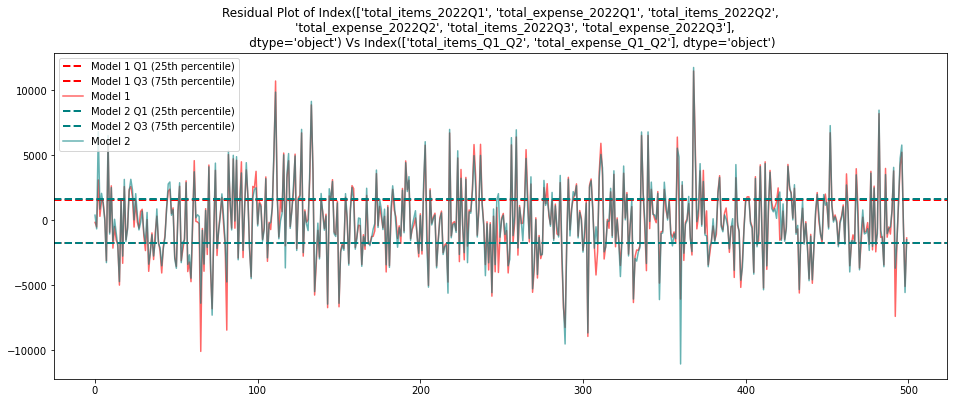

"Model 1 DecisionTreeRegressor(max_depth=5, max_features='auto', max_leaf_nodes=10,\n                      random_state=2202934) with ['total_items_2022Q1', 'total_expense_2022Q1', 'total_items_2022Q2', 'total_expense_2022Q2', 'total_items_2022Q3', 'total_expense_2022Q3'] has the smallest IQR range."

In [27]:
# compare performance after changes
model_comparer(model, model_1, final_df, df_1, drop=['customer_id'])

### Act:
Transformation has insignificant impact on model performance, but improved comprehensibility (understand expense value), interpretability (how expenses and total_items influence target), and usability (business can perform plannings during Q3 to prepare for Q4).

Therefore, this PDCA cycle is **ACCEPTED**.

## PDCA 2: Engagement within categories and overall

### Plan:
The current dataset doesn't allow for deeper insights regarding individual categories to be formulated. To understand how engagement (how many products a customer purchase) for various categories influence potential spending in Q4, I will count how many unique products were purchased for each category by the customer.

Since these features overlap with total_items, I will change total_items into the quantity of products bought by the customer (to represent overall customer engagement) to avoid multicollinearity while making the column easier to understand by business. This PDCA aims to delve into understanding how engagement in different categories and overall customer engagement (customer engagement in products as a whole) affects customer spending in Q4, to enable in-depth business insights regarding which categories to focus on to be derivable from model.

Reference:
- https://www.bcg.com/capabilities/operations/great-strategies-can-do-for-procurement

In [28]:
df_2 = df_1.copy()

### Do:

Adding categories count

In [29]:
# Filter the original DataFrame for Q1 to Q2 of 2022
dataset['quarter'] = dataset['quarter'].astype(str)                             # Convert the 'quarter' column to string
final_df_Q1_Q2 = dataset[dataset['quarter'].isin(['2022Q1', '2022Q2'])]

# Create a pivot table to get the category counts for each customer
category_count_df = final_df_Q1_Q2.pivot_table(
    index='customer_id',
    columns='category',
    values='product_id',
    aggfunc='count',
    fill_value=0
).reset_index()

# Merge the category count DataFrame with the current DataFrame
df_2 = pd.merge(df_2, category_count_df, on='customer_id', how='left')

# Fill NaN values with 0 for customers who haven't bought products from a specific category
df_2.fillna(0, inplace=True)

# drop total_items_Q1Q2 since it overlaps with the newly create columns
df_2.drop(columns=['total_items_Q1_Q2'], inplace=True)

In [30]:
# double check that filtered do not contain anything else, to ensure no data leakage
final_df_Q1_Q2[(final_df_Q1_Q2['quarter'] == '2022Q3') |
            (final_df_Q1_Q2['quarter'] == '2022Q4')]

,datetime,product_id,category,quantity,unit_price,customer_id,expense,year,quarter


In [31]:
df_2.head()

,customer_id,total_expense_2022Q4,total_expense_Q1_Q2,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys
0,a001192674,9901.78,11061.26,4,3,3,5,0,30,2,3,2,5
1,a001713895,5642.93,11518.64,0,2,2,3,1,41,1,2,2,0
2,a002096298,4643.73,13442.80,2,0,1,1,2,46,1,1,4,2
3,a002306341,6567.15,12350.53,6,0,4,3,2,21,4,1,4,2
4,a003157865,9050.38,13888.61,3,4,2,5,3,22,2,2,4,2


Adding total quantity/items

In [32]:
# Create a pivot table to get the total quantity of items bought for each customer
total_items = final_df_Q1_Q2.pivot_table(
    index='customer_id',
    values='quantity',
    aggfunc='sum',
    fill_value=0
).reset_index()

# Merge the category count DataFrame with the current DataFrame
df_2 = pd.merge(df_2, total_items, on='customer_id', how='left')

# Fill NaN values with 0
df_2.fillna(0, inplace=True)

### Check:

In [33]:
df_2.head()

,customer_id,total_expense_2022Q4,total_expense_Q1_Q2,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,quantity
0,a001192674,9901.78,11061.26,4,3,3,5,0,30,2,3,2,5,258
1,a001713895,5642.93,11518.64,0,2,2,3,1,41,1,2,2,0,660
2,a002096298,4643.73,13442.80,2,0,1,1,2,46,1,1,4,2,776
3,a002306341,6567.15,12350.53,6,0,4,3,2,21,4,1,4,2,233
4,a003157865,9050.38,13888.61,3,4,2,5,3,22,2,2,4,2,194


In [34]:
model_2 = check_performance('PDCA 2 (delving into categories + total quantity)', df_2, exclude='customer_id')

Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': 10}

                Feature  Importance
1            Automotive    0.815185
0   total_expense_Q1_Q2    0.110751
6             Groceries    0.071931
5             Furniture    0.001311
9            Stationery    0.000822
2                 Books    0.000000
3              Clothing    0.000000
4           Electronics    0.000000
7       Health & Beauty    0.000000
8                Sports    0.000000
10                 Toys    0.000000
11             quantity    0.000000

Training performance
Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.30
R-squared on Test Set: 0.82


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters,Dataset
0,Benchmark DTR,0.403236,0.63825,0.0,1.0,None,final_df
1,Pruned Benchmark DTR,0.304871,0.820964,0.274062,0.841938,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_2022Q1, total_expense_2022Q1, tot..."
2,PDCA 1 (dropping Q3 + combine across quarters),0.30398,0.81998,0.27044,0.839315,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_Q1_Q2, total_expense_Q1_Q2]"
3,PDCA 2 (delving into categories + total quantity),0.295522,0.821345,0.270774,0.839907,"{'criterion': 'squared_error', 'max_depth': No...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."


- Feature Importances indicates some of the categories are useful as they are factored into the DTR to derive the prediction.
- Small improvement in performance and explainability of model.

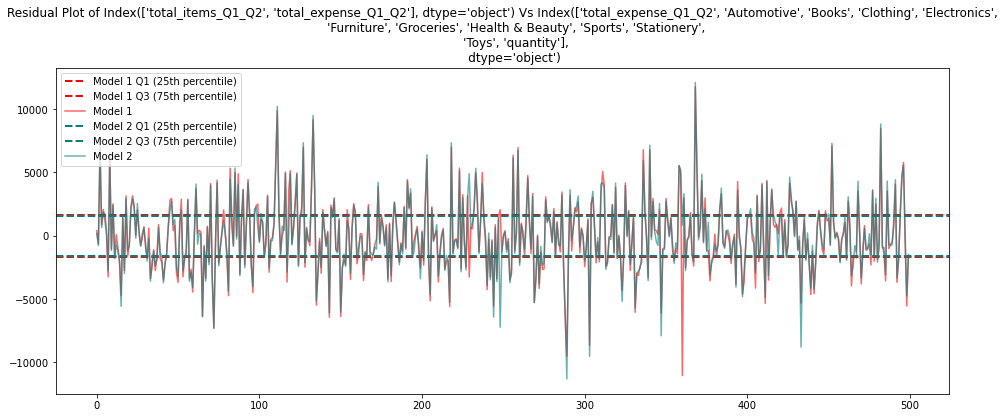

"Model 2 DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=10,\n                      random_state=2202934) with ['total_expense_Q1_Q2', 'Automotive', 'Books', 'Clothing', 'Electronics', 'Furniture', 'Groceries', 'Health & Beauty', 'Sports', 'Stationery', 'Toys', 'quantity'] has the smallest IQR range."

In [35]:
# compare performance of model after PDCA
model_comparer(model_1, model_2, df_1, df_2, drop=['customer_id'])

Addition of these features improved overall accuracy as IQR range for residual decreased. This could also be seen from the visualization where trend line for Model 2 is generally closer to 0 compared to Model 1.

### Act:
Model performance in accuracy and explainability improved. As capturing these product features allow for meaningful insights to facilitate business strategies to be formulated, this PDCA cycle is **ACCEPTED**.

## PDCA 3: Features for formulating sales strategies

### Plan:
We may understand how engagement in each category influences customer spending, however the model needs features that allows actionable sales strategies to be formulated.

Hence, I will add discounts and bundle deals into the model to understand how these factors could potentially affect customer spending, so that the business understands the efficacy of these methods to allow data-driven sales strategies to be created.

References:
- https://smallbusiness.chron.com/advantages-offering-discounts-business-25765.html
- https://www.dotactiv.com/blog/product-bundling
- https://mediaonemarketing.com.sg/what-product-bundling-examples-benefits/

In [36]:
df_3 = df_2.copy()
df_3.head()

,customer_id,total_expense_2022Q4,total_expense_Q1_Q2,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,quantity
0,a001192674,9901.78,11061.26,4,3,3,5,0,30,2,3,2,5,258
1,a001713895,5642.93,11518.64,0,2,2,3,1,41,1,2,2,0,660
2,a002096298,4643.73,13442.80,2,0,1,1,2,46,1,1,4,2,776
3,a002306341,6567.15,12350.53,6,0,4,3,2,21,4,1,4,2,233
4,a003157865,9050.38,13888.61,3,4,2,5,3,22,2,2,4,2,194


### Do:

#### Bundle deals
I will count how many cross-selling (customer buying more than 1 type of product at a time) occurrence per customer, and count that as a bundle_deal occurrence. 'bundle_deal' column will contain the count of how many bundle deals the customer engaged in.

In [37]:
# Count the number of occurrences where a customer buys more than one product on the same day
cross_sell_count_dataset = final_df_Q1_Q2.groupby(['customer_id', 'datetime'])['product_id'].count()
cross_sell_count_dataset = cross_sell_count_dataset[cross_sell_count_dataset > 1].reset_index(name='bundle_deal')

# Count the total cross-selling occurrences for each customer
cross_sell_count_total = cross_sell_count_dataset.groupby('customer_id')['bundle_deal'].count().reset_index()

# Merge the total cross-selling count back to the DataFrame
df_3 = pd.merge(df_3, cross_sell_count_total, on='customer_id', how='left')

# Fill NaN values with 0
df_3['bundle_deal'].fillna(0, inplace=True)

In [38]:
df_3.head()

,customer_id,total_expense_2022Q4,total_expense_Q1_Q2,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,quantity,bundle_deal
0,a001192674,9901.78,11061.26,4,3,3,5,0,30,2,3,2,5,258,10.0
1,a001713895,5642.93,11518.64,0,2,2,3,1,41,1,2,2,0,660,0.0
2,a002096298,4643.73,13442.80,2,0,1,1,2,46,1,1,4,2,776,2.0
3,a002306341,6567.15,12350.53,6,0,4,3,2,21,4,1,4,2,233,6.0
4,a003157865,9050.38,13888.61,3,4,2,5,3,22,2,2,4,2,194,4.0


#### Discount amount
Represents how much discount the customer received from Q1-Q2. Discount on an item is calculated by taking the highest pricing of a product_id deducting the unit_price the customer bought their product for.

In [39]:
# Calculate the maximum unit price for each product_id from Q1-Q2
max_price_per_product = final_df_Q1_Q2.groupby('product_id')['unit_price'].max().reset_index(name='max_unit_price')

# Merge the maximum unit price with dataset to form a new df
dataset_disc = pd.merge(final_df_Q1_Q2, max_price_per_product, on='product_id', how='left')

# Calculate the discount for each transaction
dataset_disc['discount_amount'] = dataset_disc['max_unit_price'] - dataset_disc['unit_price']

# Calculate the sum of discounts per customer for Q1-Q2
dataset_disc = dataset_disc.groupby('customer_id')['discount_amount'].sum().reset_index(name='total_discount')

# Merge the discount information back to the df_cross DataFrame
df_3 = pd.merge(df_3, dataset_disc, on='customer_id', how='left')

# Fill NaN values with 0 for customers who didn't receive any discounts
df_3['total_discount'].fillna(0, inplace=True)

# round off to 2d.p. / cents
df_3['total_discount'] = df_3['total_discount'].round(2)

In [40]:
df_3.head()

,customer_id,total_expense_2022Q4,total_expense_Q1_Q2,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,quantity,bundle_deal,total_discount
0,a001192674,9901.78,11061.26,4,3,3,5,0,30,2,3,2,5,258,10.0,904.30
1,a001713895,5642.93,11518.64,0,2,2,3,1,41,1,2,2,0,660,0.0,1081.24
2,a002096298,4643.73,13442.80,2,0,1,1,2,46,1,1,4,2,776,2.0,959.47
3,a002306341,6567.15,12350.53,6,0,4,3,2,21,4,1,4,2,233,6.0,668.44
4,a003157865,9050.38,13888.61,3,4,2,5,3,22,2,2,4,2,194,4.0,329.79


### Check:

In [41]:
model_3 = check_performance('PDCA 3 (sales features)', df_3, exclude='customer_id')

Best Hyperparameters: {'criterion': 'absolute_error', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': 10}

                Feature  Importance
0   total_expense_Q1_Q2    0.975884
12          bundle_deal    0.006464
13       total_discount    0.004541
7       Health & Beauty    0.003979
10                 Toys    0.003638
11             quantity    0.003283
3              Clothing    0.002211
1            Automotive    0.000000
2                 Books    0.000000
4           Electronics    0.000000
5             Furniture    0.000000
6             Groceries    0.000000
8                Sports    0.000000
9            Stationery    0.000000

Training performance
Mean Absolute Percentage Error on Train Set: 0.26
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.29
R-squared on Test Set: 0.82


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters,Dataset
0,Benchmark DTR,0.403236,0.63825,0.0,1.0,None,final_df
1,Pruned Benchmark DTR,0.304871,0.820964,0.274062,0.841938,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_2022Q1, total_expense_2022Q1, tot..."
2,PDCA 1 (dropping Q3 + combine across quarters),0.30398,0.81998,0.27044,0.839315,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_Q1_Q2, total_expense_Q1_Q2]"
3,PDCA 2 (delving into categories + total quantity),0.295522,0.821345,0.270774,0.839907,"{'criterion': 'squared_error', 'max_depth': No...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
4,PDCA 3 (sales features),0.286756,0.815136,0.260141,0.838803,"{'criterion': 'absolute_error', 'max_depth': 5...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."


- Feature Importances indicates features are useful as they are factored into the DTR to derive the prediction.
- Notable improve in accuracy (lower MAPE). However, explainability of model decreased.

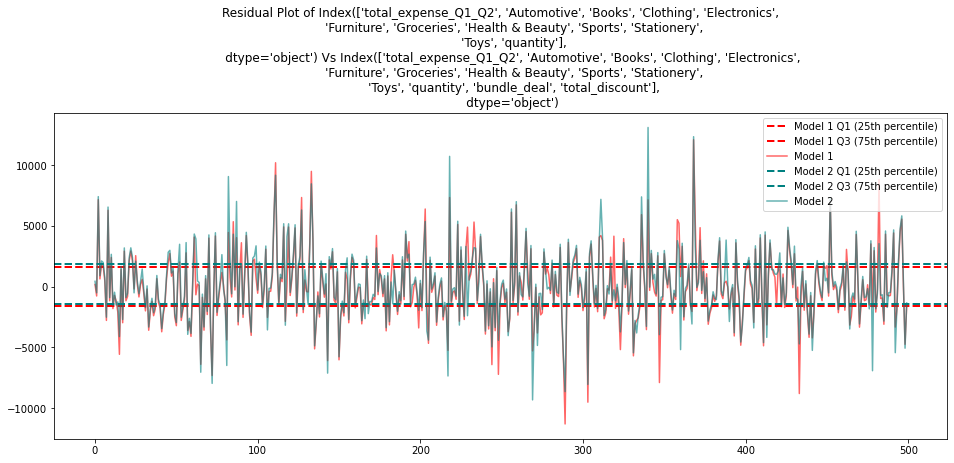

"Model 1 DecisionTreeRegressor(max_features='sqrt', max_leaf_nodes=10,\n                      random_state=2202934) with ['total_expense_Q1_Q2', 'Automotive', 'Books', 'Clothing', 'Electronics', 'Furniture', 'Groceries', 'Health & Beauty', 'Sports', 'Stationery', 'Toys', 'quantity'] has the smallest IQR range."

In [42]:
# compare performance of model
model_comparer(model_2, model_3, df_2, df_3, drop=['customer_id'])

Model 3 (Green) tends to predict higher values for customer spending at Q4.

### Act:
Improvement in model accuracy and allows business to formulate discounts and bundle_deal strategies. Hence, this cycle is **ACCEPTED** as it brings technical and business benefits to the model.

## 4. Customer Engagement and Loyalty

### Plan:
"A loyal customer who regularly shops at Retail Hypermarket are expected to spend more for Q4". This cycle aims to add a customer loyalty metric for the business to test such hypotheses and understand the effects of customer loyalty on sales potential, to formulate data-driven loyalty programs to boost customer engagement and increase sales.
> I will add the visit frequency of a customer for Q1-Q2.


Reference:
- https://www.lightspeedhq.com/blog/the-importance-of-customer-loyalty-in-retail/
- https://journals.sagepub.com/doi/full/10.1177/1096348017753521

In [43]:
df_4 = df_3.copy()
df_4.head()

,customer_id,total_expense_2022Q4,total_expense_Q1_Q2,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,quantity,bundle_deal,total_discount
0,a001192674,9901.78,11061.26,4,3,3,5,0,30,2,3,2,5,258,10.0,904.30
1,a001713895,5642.93,11518.64,0,2,2,3,1,41,1,2,2,0,660,0.0,1081.24
2,a002096298,4643.73,13442.80,2,0,1,1,2,46,1,1,4,2,776,2.0,959.47
3,a002306341,6567.15,12350.53,6,0,4,3,2,21,4,1,4,2,233,6.0,668.44
4,a003157865,9050.38,13888.61,3,4,2,5,3,22,2,2,4,2,194,4.0,329.79


### Do:

In [44]:
# count of how many times the customer visited for Q1-Q2
loyalty_metric = final_df_Q1_Q2.copy()
loyalty_metric.drop_duplicates(subset=['customer_id', 'datetime'], inplace=True) # only need 1 record per customer a day
loyalty_metric = loyalty_metric.groupby('customer_id')['datetime'].count().reset_index(name='visit_frequency')

# Integration with Existing Data
df_4 = pd.merge(df_4, loyalty_metric[['customer_id', 'visit_frequency']], on='customer_id', how='left')

In [45]:
df_4.head()

,customer_id,total_expense_2022Q4,total_expense_Q1_Q2,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,quantity,bundle_deal,total_discount,visit_frequency
0,a001192674,9901.78,11061.26,4,3,3,5,0,30,2,3,2,5,258,10.0,904.30,47
1,a001713895,5642.93,11518.64,0,2,2,3,1,41,1,2,2,0,660,0.0,1081.24,54
2,a002096298,4643.73,13442.80,2,0,1,1,2,46,1,1,4,2,776,2.0,959.47,58
3,a002306341,6567.15,12350.53,6,0,4,3,2,21,4,1,4,2,233,6.0,668.44,41
4,a003157865,9050.38,13888.61,3,4,2,5,3,22,2,2,4,2,194,4.0,329.79,45


### Check:

In [46]:
model_4 = check_performance('PDCA 4 (visit frequency)', df_4, exclude='customer_id')

Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': 10}

                Feature  Importance
14      visit_frequency    0.995408
9            Stationery    0.002058
2                 Books    0.001007
11             quantity    0.000906
4           Electronics    0.000620
0   total_expense_Q1_Q2    0.000000
1            Automotive    0.000000
3              Clothing    0.000000
5             Furniture    0.000000
6             Groceries    0.000000
7       Health & Beauty    0.000000
8                Sports    0.000000
10                 Toys    0.000000
12          bundle_deal    0.000000
13       total_discount    0.000000

Training performance
Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.30
R-squared on Test Set: 0.82


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters,Dataset
0,Benchmark DTR,0.403236,0.63825,0.0,1.0,None,final_df
1,Pruned Benchmark DTR,0.304871,0.820964,0.274062,0.841938,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_2022Q1, total_expense_2022Q1, tot..."
2,PDCA 1 (dropping Q3 + combine across quarters),0.30398,0.81998,0.27044,0.839315,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_Q1_Q2, total_expense_Q1_Q2]"
3,PDCA 2 (delving into categories + total quantity),0.295522,0.821345,0.270774,0.839907,"{'criterion': 'squared_error', 'max_depth': No...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
4,PDCA 3 (sales features),0.286756,0.815136,0.260141,0.838803,"{'criterion': 'absolute_error', 'max_depth': 5...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
5,PDCA 4 (visit frequency),0.296855,0.821699,0.269587,0.841343,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."


- Feature Importances indicates visit_frequency of a customer has a strong and relevant pattern with Q4 spending as visit_frequency has an incredibly high feature importances, indicating that the DTR mostly relies on visit_frequency to derive its prediction.
- Accuracy dropped but explainability of model increased.

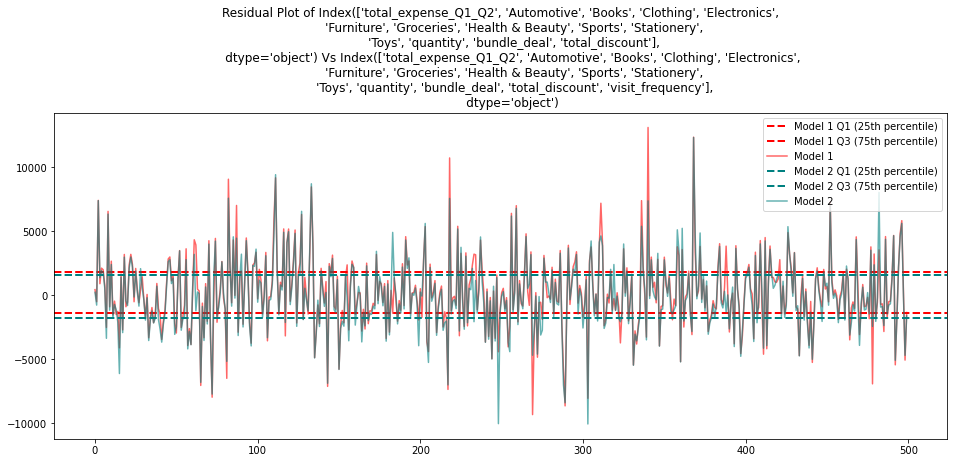

"Model 1 DecisionTreeRegressor(criterion='absolute_error', max_depth=5,\n                      max_features='sqrt', max_leaf_nodes=10,\n                      random_state=2202934) with ['total_expense_Q1_Q2', 'Automotive', 'Books', 'Clothing', 'Electronics', 'Furniture', 'Groceries', 'Health & Beauty', 'Sports', 'Stationery', 'Toys', 'quantity', 'bundle_deal', 'total_discount'] has the smallest IQR range."

In [47]:
# compare performance of model
model_comparer(model_3, model_4, df_3, df_4, drop=['customer_id'])

Model 4 (Green) makes lower predictions for customer's Q4 spending as the IQR range is lower. This is better as we don't want to overpredict revenue which can misguide business decisions by overpromising their expected revenue, potentially leading to misallocation of funds and adverse consequences. Lower predictions is more conservative as it avoids overly optimistic projections and ensures prudent financial decisions.

### Act:
This PDCA is **ACCEPTED** as it allows for loyalty programs to be constructed. Additionally, this model's predictions are more conservative with reduced likelihood of serious overpredictions which could misguide business decisions.

## 5. Customer segmentation
### Plan:
Based on EDA, I identified 4 potential customer types (a,b,c,d as first letter in customer_id). I want to segment customers so that the Model can differentiate and learn the customer engagement pattern of various customer types, allowing for personalized strategies to target various customer types to be generated (personalized works better than a general business plan as it specifically targets the customers' needs).
> I will explore different ways to segment customers:
> - One-Hot Encoding to identify trend for each customer type
> - Target Encoding to learn pattern of each customer type from the target
> - Ordinal Encoding to rank customer type

Reference: https://blog.hubspot.com/service/customer-segmentation#customer-segmentation

In [48]:
df_5 = df_4.copy()
df_5.head()

,customer_id,total_expense_2022Q4,total_expense_Q1_Q2,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,quantity,bundle_deal,total_discount,visit_frequency
0,a001192674,9901.78,11061.26,4,3,3,5,0,30,2,3,2,5,258,10.0,904.30,47
1,a001713895,5642.93,11518.64,0,2,2,3,1,41,1,2,2,0,660,0.0,1081.24,54
2,a002096298,4643.73,13442.80,2,0,1,1,2,46,1,1,4,2,776,2.0,959.47,58
3,a002306341,6567.15,12350.53,6,0,4,3,2,21,4,1,4,2,233,6.0,668.44,41
4,a003157865,9050.38,13888.61,3,4,2,5,3,22,2,2,4,2,194,4.0,329.79,45


1. Slice the first letter of customer id as customer type.

In [49]:
df_5['customer_type'] = df_5['customer_id'].str[0]

In [50]:
df_5.head()

,customer_id,total_expense_2022Q4,total_expense_Q1_Q2,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,quantity,bundle_deal,total_discount,visit_frequency,customer_type
0,a001192674,9901.78,11061.26,4,3,3,5,0,30,2,3,2,5,258,10.0,904.30,47,a
1,a001713895,5642.93,11518.64,0,2,2,3,1,41,1,2,2,0,660,0.0,1081.24,54,a
2,a002096298,4643.73,13442.80,2,0,1,1,2,46,1,1,4,2,776,2.0,959.47,58,a
3,a002306341,6567.15,12350.53,6,0,4,3,2,21,4,1,4,2,233,6.0,668.44,41,a
4,a003157865,9050.38,13888.61,3,4,2,5,3,22,2,2,4,2,194,4.0,329.79,45,a


2. Since customer type is categorical, I need to encode customer type for it to be usable by the model. I will test common encoding methods to find the most optimal encoding (best performance) method to apply on customer type.

One-hot encoding:

In [51]:
df_5_1 = df_5.copy()

In [52]:
# One-Hot Encoding
def one_hot_encode(df, columns_to_encode):
    one_hot = pd.get_dummies(df[columns_to_encode])         # Create new col for each unique value in encoded column
    df = pd.concat([df, one_hot], axis=1)                   # Concatenate encoded columns with the original DataFrame
    df = df.drop(columns=columns_to_encode)                 # Drop cols after encoded
    
    return df

df_5_1 = one_hot_encode(df_5_1, ['customer_type']) # one-hot encode customer type

In [53]:
df_5_1.head()

,customer_id,total_expense_2022Q4,total_expense_Q1_Q2,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,...,Stationery,Toys,quantity,bundle_deal,total_discount,visit_frequency,customer_type_a,customer_type_b,customer_type_c,customer_type_d
0,a001192674,9901.78,11061.26,4,3,3,5,0,30,2,...,2,5,258,10.0,904.30,47,1,0,0,0
1,a001713895,5642.93,11518.64,0,2,2,3,1,41,1,...,2,0,660,0.0,1081.24,54,1,0,0,0
2,a002096298,4643.73,13442.80,2,0,1,1,2,46,1,...,4,2,776,2.0,959.47,58,1,0,0,0
3,a002306341,6567.15,12350.53,6,0,4,3,2,21,4,...,4,2,233,6.0,668.44,41,1,0,0,0
4,a003157865,9050.38,13888.61,3,4,2,5,3,22,2,...,4,2,194,4.0,329.79,45,1,0,0,0


Target encoding:

In [54]:
df_5_2 = df_5.copy()

In [55]:
# Target Encoding
def target_encode(df, columns_to_encode, target_column):
    target_encoders = {}                                      # Dictionary to store target encoders for each column
    df_encoded = df.copy()                                    # Create a copy of the DataFrame to avoid modifying the original

    for col in columns_to_encode:
        target_encoder = TargetEncoder()                            # Init the TargetEncoder
        df_encoded[col + '_encoded'] = target_encoder.fit_transform(df_encoded[col], df_encoded[target_column])  # Fit and transform the column
        target_encoders[col] = target_encoder                       # Store the target encoder in the dictionary

    df_encoded.drop(columns=columns_to_encode, inplace=True)  # Drop the original columns
    return df_encoded, target_encoders

df_5_2, target_encoders = target_encode(df_5_2, ['customer_type'], TARGET_COLUMN)

In [56]:
df_5_2.head()

,customer_id,total_expense_2022Q4,total_expense_Q1_Q2,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,quantity,bundle_deal,total_discount,visit_frequency,customer_type_encoded
0,a001192674,9901.78,11061.26,4,3,3,5,0,30,2,3,2,5,258,10.0,904.30,47,9835.14304
1,a001713895,5642.93,11518.64,0,2,2,3,1,41,1,2,2,0,660,0.0,1081.24,54,9835.14304
2,a002096298,4643.73,13442.80,2,0,1,1,2,46,1,1,4,2,776,2.0,959.47,58,9835.14304
3,a002306341,6567.15,12350.53,6,0,4,3,2,21,4,1,4,2,233,6.0,668.44,41,9835.14304
4,a003157865,9050.38,13888.61,3,4,2,5,3,22,2,2,4,2,194,4.0,329.79,45,9835.14304


In [57]:
df_5_2.customer_type_encoded.unique()

array([9835.14303965, 8905.94335832, 9621.87190332, 9838.50288401])

Ordinal encoding:
> In order to ordinal encode, I need to rank each customer type based on their average spending behavior for each quarter.

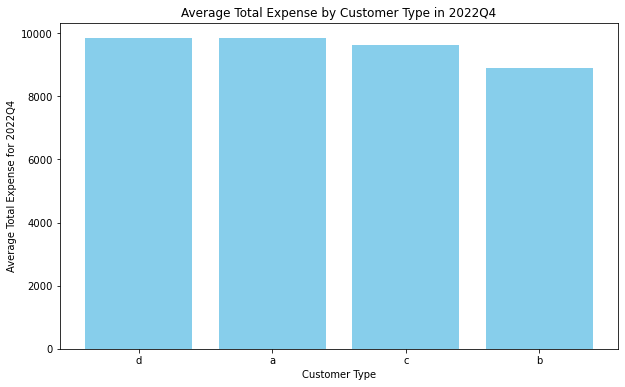

In [58]:
target_col = 'total_expense_2022Q4' # adjust other Quarters to see trend

# Group data by customer_type and calculate average total_expense
average_expense_by_type = df_5.groupby('customer_type')[target_col].mean().reset_index()

# Sort the DataFrame by average total_expense in descending order
average_expense_by_type = average_expense_by_type.sort_values(by=target_col, ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(average_expense_by_type['customer_type'], average_expense_by_type[target_col], color='skyblue')
plt.xlabel('Customer Type')
plt.ylabel('Average Total Expense for 2022Q4')
plt.title('Average Total Expense by Customer Type in 2022Q4')
plt.show()

- Customer Type d, a, c have closely similar average spending for all quarters. Customer Type A are top spending customers for Q1 to Q2, followed by Type D. 

- Type C is the 2nd top spending customer type for Q3.

- However, customer Type B has the least average expenditure for all quarters.

I will try 2 different ordinal encoding:
1. d,a,c as 1 and b as 0 since d,a,c are more valuable customers as they spend more money.
2. d,a as 2, c as 1, and b as 0. (To differentiate customer types further)

In [59]:
df_5_3 = df_5.copy()

# Ordinal Encoding 1
encoding_customer_type_3 = {'b': 0, 'a': 1, 'c': 1, 'd': 1}

# Apply the mapping to the 'customer_type' column
df_5_3['customer_type_encoded'] = df_5_3['customer_type'].map(encoding_customer_type_3)

# Drop the original 'customer_type' column
df_5_3.drop(columns=['customer_type'], inplace=True)

df_5_3.head()

,customer_id,total_expense_2022Q4,total_expense_Q1_Q2,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,quantity,bundle_deal,total_discount,visit_frequency,customer_type_encoded
0,a001192674,9901.78,11061.26,4,3,3,5,0,30,2,3,2,5,258,10.0,904.30,47,1
1,a001713895,5642.93,11518.64,0,2,2,3,1,41,1,2,2,0,660,0.0,1081.24,54,1
2,a002096298,4643.73,13442.80,2,0,1,1,2,46,1,1,4,2,776,2.0,959.47,58,1
3,a002306341,6567.15,12350.53,6,0,4,3,2,21,4,1,4,2,233,6.0,668.44,41,1
4,a003157865,9050.38,13888.61,3,4,2,5,3,22,2,2,4,2,194,4.0,329.79,45,1


In [60]:
df_5_4 = df_5.copy()

# Ordinal Encoding 1
encoding_customer_type_4 = {'b': 0, 'a': 2, 'c': 1, 'd': 2}

# Apply the mapping to the 'customer_type' column
df_5_4['customer_type_encoded'] = df_5_4['customer_type'].map(encoding_customer_type_4)

# Drop the original 'customer_type' column
df_5_4.drop(columns=['customer_type'], inplace=True)

df_5_4.head()

,customer_id,total_expense_2022Q4,total_expense_Q1_Q2,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,quantity,bundle_deal,total_discount,visit_frequency,customer_type_encoded
0,a001192674,9901.78,11061.26,4,3,3,5,0,30,2,3,2,5,258,10.0,904.30,47,2
1,a001713895,5642.93,11518.64,0,2,2,3,1,41,1,2,2,0,660,0.0,1081.24,54,2
2,a002096298,4643.73,13442.80,2,0,1,1,2,46,1,1,4,2,776,2.0,959.47,58,2
3,a002306341,6567.15,12350.53,6,0,4,3,2,21,4,1,4,2,233,6.0,668.44,41,2
4,a003157865,9050.38,13888.61,3,4,2,5,3,22,2,2,4,2,194,4.0,329.79,45,2


### Check:

In [61]:
model_5_1 = check_performance('PDCA 5 (one-hot customer)', df_5_1, exclude='customer_id')

Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None}

                Feature  Importance
11             quantity    0.737126
0   total_expense_Q1_Q2    0.232547
10                 Toys    0.019432
12          bundle_deal    0.002883
13       total_discount    0.002627
14      visit_frequency    0.002185
1            Automotive    0.001218
6             Groceries    0.000986
5             Furniture    0.000746
7       Health & Beauty    0.000250
17      customer_type_c    0.000000
16      customer_type_b    0.000000
15      customer_type_a    0.000000
9            Stationery    0.000000
8                Sports    0.000000
4           Electronics    0.000000
3              Clothing    0.000000
2                 Books    0.000000
18      customer_type_d    0.000000

Training performance
Mean Absolute Percentage Error on Train Set: 0.27
R-squared on Train Set: 0.85

Testing performance
Mean Absolute Percentage Error on Test S

,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters,Dataset
0,Benchmark DTR,0.403236,0.63825,0.0,1.0,None,final_df
1,Pruned Benchmark DTR,0.304871,0.820964,0.274062,0.841938,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_2022Q1, total_expense_2022Q1, tot..."
2,PDCA 1 (dropping Q3 + combine across quarters),0.30398,0.81998,0.27044,0.839315,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_Q1_Q2, total_expense_Q1_Q2]"
3,PDCA 2 (delving into categories + total quantity),0.295522,0.821345,0.270774,0.839907,"{'criterion': 'squared_error', 'max_depth': No...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
4,PDCA 3 (sales features),0.286756,0.815136,0.260141,0.838803,"{'criterion': 'absolute_error', 'max_depth': 5...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
5,PDCA 4 (visit frequency),0.296855,0.821699,0.269587,0.841343,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
6,PDCA 5 (one-hot customer),0.301601,0.818476,0.265442,0.845375,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."


In [62]:
model_5_2 = check_performance('PDCA 5 (target customer)', df_5_2, exclude='customer_id')

Best Hyperparameters: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': 10}

                  Feature  Importance
14        visit_frequency    0.978691
12            bundle_deal    0.008409
0     total_expense_Q1_Q2    0.004556
13         total_discount    0.004520
3                Clothing    0.003825
1              Automotive    0.000000
2                   Books    0.000000
4             Electronics    0.000000
5               Furniture    0.000000
6               Groceries    0.000000
7         Health & Beauty    0.000000
8                  Sports    0.000000
9              Stationery    0.000000
10                   Toys    0.000000
11               quantity    0.000000
15  customer_type_encoded    0.000000

Training performance
Mean Absolute Percentage Error on Train Set: 0.26
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.29
R-squared on Test Set: 0.82


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters,Dataset
0,Benchmark DTR,0.403236,0.63825,0.0,1.0,None,final_df
1,Pruned Benchmark DTR,0.304871,0.820964,0.274062,0.841938,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_2022Q1, total_expense_2022Q1, tot..."
2,PDCA 1 (dropping Q3 + combine across quarters),0.30398,0.81998,0.27044,0.839315,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_Q1_Q2, total_expense_Q1_Q2]"
3,PDCA 2 (delving into categories + total quantity),0.295522,0.821345,0.270774,0.839907,"{'criterion': 'squared_error', 'max_depth': No...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
4,PDCA 3 (sales features),0.286756,0.815136,0.260141,0.838803,"{'criterion': 'absolute_error', 'max_depth': 5...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
5,PDCA 4 (visit frequency),0.296855,0.821699,0.269587,0.841343,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
6,PDCA 5 (one-hot customer),0.301601,0.818476,0.265442,0.845375,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
7,PDCA 5 (target customer),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."


In [63]:
model_5_3 = check_performance('PDCA 5 (segregating customer B)', df_5_3, exclude='customer_id')

Best Hyperparameters: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': 10}

                  Feature  Importance
14        visit_frequency    0.978691
12            bundle_deal    0.008409
0     total_expense_Q1_Q2    0.004556
13         total_discount    0.004520
3                Clothing    0.003825
1              Automotive    0.000000
2                   Books    0.000000
4             Electronics    0.000000
5               Furniture    0.000000
6               Groceries    0.000000
7         Health & Beauty    0.000000
8                  Sports    0.000000
9              Stationery    0.000000
10                   Toys    0.000000
11               quantity    0.000000
15  customer_type_encoded    0.000000

Training performance
Mean Absolute Percentage Error on Train Set: 0.26
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.29
R-squared on Test Set: 0.82


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters,Dataset
0,Benchmark DTR,0.403236,0.63825,0.0,1.0,None,final_df
1,Pruned Benchmark DTR,0.304871,0.820964,0.274062,0.841938,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_2022Q1, total_expense_2022Q1, tot..."
2,PDCA 1 (dropping Q3 + combine across quarters),0.30398,0.81998,0.27044,0.839315,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_Q1_Q2, total_expense_Q1_Q2]"
3,PDCA 2 (delving into categories + total quantity),0.295522,0.821345,0.270774,0.839907,"{'criterion': 'squared_error', 'max_depth': No...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
4,PDCA 3 (sales features),0.286756,0.815136,0.260141,0.838803,"{'criterion': 'absolute_error', 'max_depth': 5...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
5,PDCA 4 (visit frequency),0.296855,0.821699,0.269587,0.841343,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
6,PDCA 5 (one-hot customer),0.301601,0.818476,0.265442,0.845375,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
7,PDCA 5 (target customer),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
8,PDCA 5 (segregating customer B),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."


In [64]:
model_5_4 = check_performance('PDCA 5 (ordinal customer)', df_5_4, exclude='customer_id')

Best Hyperparameters: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': 10}

                  Feature  Importance
14        visit_frequency    0.978691
12            bundle_deal    0.008409
0     total_expense_Q1_Q2    0.004556
13         total_discount    0.004520
3                Clothing    0.003825
1              Automotive    0.000000
2                   Books    0.000000
4             Electronics    0.000000
5               Furniture    0.000000
6               Groceries    0.000000
7         Health & Beauty    0.000000
8                  Sports    0.000000
9              Stationery    0.000000
10                   Toys    0.000000
11               quantity    0.000000
15  customer_type_encoded    0.000000

Training performance
Mean Absolute Percentage Error on Train Set: 0.26
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.29
R-squared on Test Set: 0.82


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters,Dataset
0,Benchmark DTR,0.403236,0.63825,0.0,1.0,None,final_df
1,Pruned Benchmark DTR,0.304871,0.820964,0.274062,0.841938,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_2022Q1, total_expense_2022Q1, tot..."
2,PDCA 1 (dropping Q3 + combine across quarters),0.30398,0.81998,0.27044,0.839315,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_Q1_Q2, total_expense_Q1_Q2]"
3,PDCA 2 (delving into categories + total quantity),0.295522,0.821345,0.270774,0.839907,"{'criterion': 'squared_error', 'max_depth': No...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
4,PDCA 3 (sales features),0.286756,0.815136,0.260141,0.838803,"{'criterion': 'absolute_error', 'max_depth': 5...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
5,PDCA 4 (visit frequency),0.296855,0.821699,0.269587,0.841343,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
6,PDCA 5 (one-hot customer),0.301601,0.818476,0.265442,0.845375,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
7,PDCA 5 (target customer),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
8,PDCA 5 (segregating customer B),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
9,PDCA 5 (ordinal customer),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."


- Improvement in model performance for all models except one-hot encoded.
- Encoding method of Target and Ordinal both lead to same performance.

### Act:
Choosing either target encoding or ordinal encoding for customer type results in very slight improvement in model accuracy (MAPE) and explainability (R-Square), indicating that customer type likely plays a role in influencing customer spending patterns.

Since target and ordinal produces the same results for Decision Tree, ordinal encoding of segregating customer B is preferred due to its simplicity in understanding the represented values (differentiate Type B as weak spender). Ordinal encoding also preserves the model's reusability for future predictions unlike Target Encoding, since potential changes in customer spending would make the old target encoded values inaccurate in meaning.

Implementing customer type enhances the model's accuracy, explainability, and facilitates the creation of customized business strategies for normal spenders and weak spenders.

### Wrap-up:

In [65]:
df_final = df_5_3.copy()                             # final df after PDCA
df_final.drop(columns=['customer_id'], inplace=True) # customer_id is not used as predictor

In [66]:
df_final.head()

,total_expense_2022Q4,total_expense_Q1_Q2,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,quantity,bundle_deal,total_discount,visit_frequency,customer_type_encoded
0,9901.78,11061.26,4,3,3,5,0,30,2,3,2,5,258,10.0,904.30,47,1
1,5642.93,11518.64,0,2,2,3,1,41,1,2,2,0,660,0.0,1081.24,54,1
2,4643.73,13442.80,2,0,1,1,2,46,1,1,4,2,776,2.0,959.47,58,1
3,6567.15,12350.53,6,0,4,3,2,21,4,1,4,2,233,6.0,668.44,41,1
4,9050.38,13888.61,3,4,2,5,3,22,2,2,4,2,194,4.0,329.79,45,1


In [67]:
final_dtr = check_performance('DTR', df_final)

Best Hyperparameters: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': 10}

                  Feature  Importance
14        visit_frequency    0.978691
12            bundle_deal    0.008409
0     total_expense_Q1_Q2    0.004556
13         total_discount    0.004520
3                Clothing    0.003825
1              Automotive    0.000000
2                   Books    0.000000
4             Electronics    0.000000
5               Furniture    0.000000
6               Groceries    0.000000
7         Health & Beauty    0.000000
8                  Sports    0.000000
9              Stationery    0.000000
10                   Toys    0.000000
11               quantity    0.000000
15  customer_type_encoded    0.000000

Training performance
Mean Absolute Percentage Error on Train Set: 0.26
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.29
R-squared on Test Set: 0.82


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters,Dataset
0,Benchmark DTR,0.403236,0.63825,0.0,1.0,None,final_df
1,Pruned Benchmark DTR,0.304871,0.820964,0.274062,0.841938,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_2022Q1, total_expense_2022Q1, tot..."
2,PDCA 1 (dropping Q3 + combine across quarters),0.30398,0.81998,0.27044,0.839315,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_Q1_Q2, total_expense_Q1_Q2]"
3,PDCA 2 (delving into categories + total quantity),0.295522,0.821345,0.270774,0.839907,"{'criterion': 'squared_error', 'max_depth': No...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
4,PDCA 3 (sales features),0.286756,0.815136,0.260141,0.838803,"{'criterion': 'absolute_error', 'max_depth': 5...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
5,PDCA 4 (visit frequency),0.296855,0.821699,0.269587,0.841343,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
6,PDCA 5 (one-hot customer),0.301601,0.818476,0.265442,0.845375,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
7,PDCA 5 (target customer),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
8,PDCA 5 (segregating customer B),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
9,PDCA 5 (ordinal customer),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."


#### Permutation Importance

In [68]:
X = df_final.drop([TARGET_COLUMN], axis=1)  # predictors
y = df_final[TARGET_COLUMN]                 # target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [69]:
from sklearn.inspection import permutation_importance

def find_perm_importance(model, X_test, y_test, random_state=SEED, n_repeats=30):
    """
    Calculate permutation importance for a given model.

    Parameters:
    - model: The trained regression model for which to calculate permutation importance.
    - X_test: The feature matrix of the test set.
    - y_test: The true labels of the test set.
    - random_state: Random seed for reproducibility.
    - n_repeats: Number of times to permute each feature.

    Returns:
    - feature_importance_df: A DataFrame containing feature names, mean importance, and standard deviation.
    """
    # Calculate permutation importance
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=n_repeats, random_state=random_state)

    # Mean importance for each feature
    feature_importance_mean = perm_importance.importances_mean

    # Standard deviation of importance for each feature
    feature_importance_std = perm_importance.importances_std

    # Create a DataFrame to visualize feature importance
    feature_importance_df = pd.DataFrame({'Feature': X_test.columns, 'Importance Mean': feature_importance_mean, 'Importance Std': feature_importance_std})
    feature_importance_df = feature_importance_df.sort_values(by='Importance Mean', ascending=False)

    print("Permutation Importances:\n")
    print(feature_importance_df)

In [70]:
find_perm_importance(final_dtr, X_test, y_test)

Permutation Importances:

                  Feature  Importance Mean  Importance Std
14        visit_frequency         1.855596        0.093445
13         total_discount         0.065048        0.012712
12            bundle_deal         0.002102        0.003462
3                Clothing         0.001872        0.003640
1              Automotive         0.000000        0.000000
2                   Books         0.000000        0.000000
4             Electronics         0.000000        0.000000
5               Furniture         0.000000        0.000000
6               Groceries         0.000000        0.000000
7         Health & Beauty         0.000000        0.000000
8                  Sports         0.000000        0.000000
9              Stationery         0.000000        0.000000
10                   Toys         0.000000        0.000000
11               quantity         0.000000        0.000000
15  customer_type_encoded         0.000000        0.000000
0     total_expense_Q1_Q2     

In [71]:
# Calculate the correlation matrix
corr_mat = df_final.corr()

# Display the correlation matrix with a blue color gradient
corr_mat.style.background_gradient(cmap='Blues')

,total_expense_2022Q4,total_expense_Q1_Q2,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,quantity,bundle_deal,total_discount,visit_frequency,customer_type_encoded
total_expense_2022Q4,1.000000,0.878001,0.784258,-0.150067,-0.110979,0.783372,0.802892,0.636484,-0.141342,-0.101777,-0.136358,-0.138260,0.626305,0.600675,0.702608,0.839764,0.058378
total_expense_Q1_Q2,0.878001,1.000000,0.821017,-0.143884,-0.122509,0.882625,0.913507,0.681254,-0.108339,-0.086302,-0.150466,-0.137596,0.677014,0.674586,0.775214,0.916800,0.043693
Automotive,0.784258,0.821017,1.000000,-0.030828,-0.028968,0.756148,0.770346,0.454328,-0.043607,-0.011801,-0.046956,-0.041402,0.443480,0.714882,0.723295,0.751851,0.041377
Books,-0.150067,-0.143884,-0.030828,1.000000,0.210537,-0.032033,-0.040577,-0.401641,0.179193,0.233197,0.190757,0.187540,-0.409551,0.197851,-0.007815,-0.217585,-0.005432
Clothing,-0.110979,-0.122509,-0.028968,0.210537,1.000000,-0.026175,-0.040272,-0.378806,0.158212,0.183124,0.185842,0.194531,-0.384637,0.194926,-0.013078,-0.204715,0.036263
Electronics,0.783372,0.882625,0.756148,-0.032033,-0.026175,1.000000,0.762625,0.458006,-0.048778,0.001361,-0.039366,-0.052056,0.443195,0.720623,0.839511,0.751606,0.055420
Furniture,0.802892,0.913507,0.770346,-0.040577,-0.040272,0.762625,1.000000,0.474244,-0.044534,-0.026005,-0.048174,-0.055163,0.462431,0.715457,0.719810,0.766018,0.039850
Groceries,0.636484,0.681254,0.454328,-0.401641,-0.378806,0.458006,0.474244,1.000000,-0.401895,-0.373040,-0.404628,-0.374572,0.983891,0.142945,0.415017,0.881051,0.005924
Health & Beauty,-0.141342,-0.108339,-0.043607,0.179193,0.158212,-0.048778,-0.044534,-0.401895,1.000000,0.195957,0.188491,0.182688,-0.394879,0.189991,-0.020181,-0.233023,0.027167
Sports,-0.101777,-0.086302,-0.011801,0.233197,0.183124,0.001361,-0.026005,-0.373040,0.195957,1.000000,0.230500,0.165996,-0.378776,0.228199,0.031643,-0.186640,0.033221


- Based on Permutation Feature Importances, total_expense_Q1_Q2 may negatively impact the model's performance.
- Based on Pearson's Correlation Test, total_expense_Q1_Q2 Total is highly collinear with many features, suggesting information overlaps with other features. This suggests that Total Expense may not provide unique information and removing it can enhance model generalization. 

Hence, this column should be dropped to improve interpretability to uncover the true drivers high spending; can't formulate a business strategy that simply tell customers to spend more than their Q1-Q2 spending (not actionable). Need actionable insights to get them to spend more instead, which is why I choose to keep other features rather than total expense.

In [72]:
results.sort_values(by=['MAPE Test'])

,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters,Dataset
7,PDCA 5 (target customer),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
8,PDCA 5 (segregating customer B),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
9,PDCA 5 (ordinal customer),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
10,DTR,0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
4,PDCA 3 (sales features),0.286756,0.815136,0.260141,0.838803,"{'criterion': 'absolute_error', 'max_depth': 5...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
3,PDCA 2 (delving into categories + total quantity),0.295522,0.821345,0.270774,0.839907,"{'criterion': 'squared_error', 'max_depth': No...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
5,PDCA 4 (visit frequency),0.296855,0.821699,0.269587,0.841343,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
6,PDCA 5 (one-hot customer),0.301601,0.818476,0.265442,0.845375,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
2,PDCA 1 (dropping Q3 + combine across quarters),0.30398,0.81998,0.27044,0.839315,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_Q1_Q2, total_expense_Q1_Q2]"
1,Pruned Benchmark DTR,0.304871,0.820964,0.274062,0.841938,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_2022Q1, total_expense_2022Q1, tot..."


#### Dropping total expense

In [73]:
df_final_drop = df_final.drop(columns=['total_expense_Q1_Q2'])

In [74]:
df_final_drop.head()

,total_expense_2022Q4,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,quantity,bundle_deal,total_discount,visit_frequency,customer_type_encoded
0,9901.78,4,3,3,5,0,30,2,3,2,5,258,10.0,904.30,47,1
1,5642.93,0,2,2,3,1,41,1,2,2,0,660,0.0,1081.24,54,1
2,4643.73,2,0,1,1,2,46,1,1,4,2,776,2.0,959.47,58,1
3,6567.15,6,0,4,3,2,21,4,1,4,2,233,6.0,668.44,41,1
4,9050.38,3,4,2,5,3,22,2,2,4,2,194,4.0,329.79,45,1


In [75]:
final_dtr = check_performance('PDCA 5 (segregate B) drop expenses', df_final_drop)

Best Hyperparameters: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': 10}

                  Feature  Importance
13        visit_frequency    0.980911
2                Clothing    0.003802
10               quantity    0.003548
11            bundle_deal    0.003421
12         total_discount    0.003253
6         Health & Beauty    0.002684
14  customer_type_encoded    0.002381
0              Automotive    0.000000
1                   Books    0.000000
3             Electronics    0.000000
4               Furniture    0.000000
5               Groceries    0.000000
7                  Sports    0.000000
8              Stationery    0.000000
9                    Toys    0.000000

Training performance
Mean Absolute Percentage Error on Train Set: 0.26
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.29
R-squared on Test Set: 0.81


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters,Dataset
0,Benchmark DTR,0.403236,0.63825,0.0,1.0,None,final_df
1,Pruned Benchmark DTR,0.304871,0.820964,0.274062,0.841938,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_2022Q1, total_expense_2022Q1, tot..."
2,PDCA 1 (dropping Q3 + combine across quarters),0.30398,0.81998,0.27044,0.839315,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_Q1_Q2, total_expense_Q1_Q2]"
3,PDCA 2 (delving into categories + total quantity),0.295522,0.821345,0.270774,0.839907,"{'criterion': 'squared_error', 'max_depth': No...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
4,PDCA 3 (sales features),0.286756,0.815136,0.260141,0.838803,"{'criterion': 'absolute_error', 'max_depth': 5...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
5,PDCA 4 (visit frequency),0.296855,0.821699,0.269587,0.841343,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
6,PDCA 5 (one-hot customer),0.301601,0.818476,0.265442,0.845375,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
7,PDCA 5 (target customer),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
8,PDCA 5 (segregating customer B),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
9,PDCA 5 (ordinal customer),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."


Dropping total expenses worsened the model performance. However, keeping expense as a predictor could hinder interpretability and make it challenging to uncover true drivers of customer engagement. Therefore, I will try Random Forest as this ensemble method consists of multiple Decision Trees, making it robust to noisy features (if expenses is truly irrelevant) and overfitting.

## Model Selection

### Plan:
The current accuracy of the DTR is atleast 70% and the explainability is around 82% (goodness of fit). While this performance is acceptable. In retail, the relationships between factors affecting customer spending are intricate and nonlinear and a single Decision Tree may not be able to capture them completely. Therefore, I will attempt Random Forest, an ensemble method that combines multiple decision trees, to adeptly capture complex interactions and intricacies that may elude from a single Decision Tree. 

Having a model that is better able at capturing nuances and patterns not only improves the performance of the model (which the business can benefit from more accurate predictions), but it also allows for deeper and in-depth insights on how various factors simulatanously influence the customer spending to be derived through interpreting the model.

Reference:
- https://www.sciencedirect.com/science/article/pii/S1319157823000228

In [76]:
X = df_final.drop([TARGET_COLUMN], axis=1)  # predictors
y = df_final[TARGET_COLUMN]                 # target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

### Do (Random Forest Regressor):
I can include total_expense_Q1_Q2 for RF as its robust to noise.

In [77]:
df_final.head()

,total_expense_2022Q4,total_expense_Q1_Q2,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,quantity,bundle_deal,total_discount,visit_frequency,customer_type_encoded
0,9901.78,11061.26,4,3,3,5,0,30,2,3,2,5,258,10.0,904.30,47,1
1,5642.93,11518.64,0,2,2,3,1,41,1,2,2,0,660,0.0,1081.24,54,1
2,4643.73,13442.80,2,0,1,1,2,46,1,1,4,2,776,2.0,959.47,58,1
3,6567.15,12350.53,6,0,4,3,2,21,4,1,4,2,233,6.0,668.44,41,1
4,9050.38,13888.61,3,4,2,5,3,22,2,2,4,2,194,4.0,329.79,45,1


In [78]:
from sklearn.ensemble import RandomForestRegressor

# find best params for chosen DTR
best_params = param_tuning(final_dtr, X_train, y_train)

# Build the RandomForestRegressor
rf_regressor = RandomForestRegressor(**best_params, n_jobs=-1, bootstrap=False, random_state=SEED)
#                                                   n_jobs makes Rf run in parallel, 
#                                                              disable bootstrap to train using all training data
rf_regressor.fit(X_train, y_train)

Best Hyperparameters: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': 10}



RandomForestRegressor(bootstrap=False, criterion='absolute_error',
                      max_features='sqrt', max_leaf_nodes=10, n_jobs=-1,
                      random_state=2202934)

I can simply use 80-20 train-test for RF because RF is not prone to overfit. Thus, I do not need to employ KFold cross-validation for training.

#### Model Evaluator
Report on model's fit and how predictors explain prediction.

#### Usage:
Provide the trained model, Predictors DataFrame, Target DataFrame, original Predictors DataFrame (to obtain column names), are you evaluating with model's training dataset? [True/False] default=False, max_depth=[display branches to which level].

In [79]:
from sklearn import tree

def understand_model(model, X, y, cols, training=False, tree_to_visualize=None):
    y_pred = model.predict(X)  # Predict using the model and predictors
            
    # for black-box models like DTR
    if training and tree_to_visualize:
        # Visualize the selected tree
        plt.figure(figsize=(16, 20))
        #                                 -1 because indexing starts from 0
        tree.plot_tree(rf_regressor.estimators_[tree_to_visualize-1], feature_names=X_train.columns, filled=True, fontsize=10)
        plt.show()
        
    else:
        # Visualize the fit
        plt.figure(figsize=(10, 10))
        plt.scatter(y, y_pred, alpha=0.2)
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title("Actual vs Predicted Values")
        plt.grid(True)
        plt.show()
    
    print(f"R-squared (Goodness of Fit): {r2_score(y, y_pred):.2f}")

Interpreting Random Forest (RF):

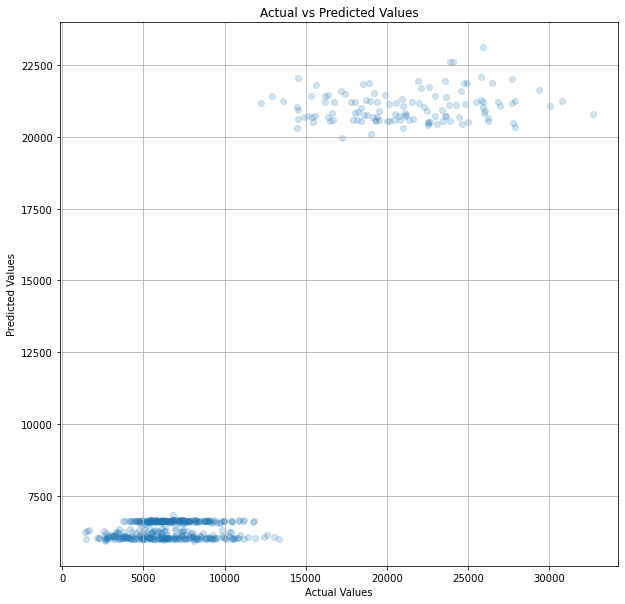

R-squared (Goodness of Fit): 0.83


In [80]:
understand_model(rf_regressor, X_test, y_test, X, training=False)

There seems to be 2 main clusters for the Random Forest's predictions: those who spend below around 14,000 and those who spend above 14,000. 

The RF Model suggests that its possible to make this into a classification problem too as the RF Model produces 2 'clusters' for its predictions.

### Check (Random Forest):

In [81]:
# Print feature importances
feature_importances = list(zip(X.columns, rf_regressor.feature_importances_))
feature_importances_df = pd.DataFrame(feature_importances, columns=['Feature', 'Importance'])
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df)

print('Training performance')
mape_train, r2_train = evaluate_model(rf_regressor, X_train, y_train, 'Train')

print('\nTesting performance')
mape_test, r2_test = evaluate_model(rf_regressor, X_test, y_test, 'Test')

store_model('Random Forest', mape_test, r2_test, mape_train, r2_train, list(X.columns), best_params)

                  Feature  Importance
14        visit_frequency    0.266243
11               quantity    0.197445
0     total_expense_Q1_Q2    0.178659
6               Groceries    0.144987
5               Furniture    0.063255
4             Electronics    0.058868
1              Automotive    0.056139
13         total_discount    0.028270
12            bundle_deal    0.001934
3                Clothing    0.001888
7         Health & Beauty    0.000667
15  customer_type_encoded    0.000491
9              Stationery    0.000442
8                  Sports    0.000339
2                   Books    0.000272
10                   Toys    0.000100
Training performance
Mean Absolute Percentage Error on Train Set: 0.26
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.28
R-squared on Test Set: 0.83


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters,Dataset
0,Benchmark DTR,0.403236,0.63825,0.0,1.0,None,final_df
1,Pruned Benchmark DTR,0.304871,0.820964,0.274062,0.841938,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_2022Q1, total_expense_2022Q1, tot..."
2,PDCA 1 (dropping Q3 + combine across quarters),0.30398,0.81998,0.27044,0.839315,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_Q1_Q2, total_expense_Q1_Q2]"
3,PDCA 2 (delving into categories + total quantity),0.295522,0.821345,0.270774,0.839907,"{'criterion': 'squared_error', 'max_depth': No...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
4,PDCA 3 (sales features),0.286756,0.815136,0.260141,0.838803,"{'criterion': 'absolute_error', 'max_depth': 5...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
5,PDCA 4 (visit frequency),0.296855,0.821699,0.269587,0.841343,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
6,PDCA 5 (one-hot customer),0.301601,0.818476,0.265442,0.845375,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
7,PDCA 5 (target customer),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
8,PDCA 5 (segregating customer B),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
9,PDCA 5 (ordinal customer),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."


Performing Feature Importances to find out usefulness of predictors on prediction:

In [82]:
find_perm_importance(rf_regressor, X_test, y_test)

Permutation Importances:

                  Feature  Importance Mean  Importance Std
14        visit_frequency         0.252079        0.017874
0     total_expense_Q1_Q2         0.176316        0.013478
6               Groceries         0.015174        0.003822
11               quantity         0.012624        0.003701
1              Automotive         0.003606        0.002078
13         total_discount         0.002010        0.002229
4             Electronics         0.001927        0.001233
3                Clothing         0.001365        0.001363
5               Furniture         0.000781        0.000782
7         Health & Beauty         0.000345        0.000594
12            bundle_deal         0.000138        0.000676
8                  Sports        -0.000004        0.000124
2                   Books        -0.000022        0.000075
15  customer_type_encoded        -0.000041        0.000287
9              Stationery        -0.000069        0.000097
10                   Toys     

Create new predictors df without unimportant features:

In [83]:
useless = ['Toys', 'Stationery', 'customer_type_encoded', 'Books', 'Sports']
X_train_drop = X_train.drop(useless, axis=1)
X_test_drop = X_test.drop(useless, axis=1)

In [84]:
# Build the RandomForestRegressor
rf_regressor_drop = RandomForestRegressor(**best_params, n_jobs=-1, 
                                          bootstrap=False, random_state=SEED)
rf_regressor_drop.fit(X_train_drop, y_train)

RandomForestRegressor(bootstrap=False, criterion='absolute_error',
                      max_features='sqrt', max_leaf_nodes=10, n_jobs=-1,
                      random_state=2202934)

In [85]:
# Print feature importances
feature_importances = list(zip(X_train_drop.columns, rf_regressor_drop.feature_importances_))
feature_importances_df = pd.DataFrame(feature_importances, columns=['Feature', 'Importance'])
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df)

print('Training performance')
mape_train, r2_train = evaluate_model(rf_regressor_drop, X_train_drop, y_train, 'Train')

print('\nTesting performance')
mape_test, r2_test = evaluate_model(rf_regressor_drop, X_test_drop, y_test, 'Test')

store_model('Random Forest dropping unimportant', mape_test, r2_test,
            mape_train, r2_train, list(X.columns), best_params)

                Feature  Importance
0   total_expense_Q1_Q2    0.267167
10      visit_frequency    0.256522
7              quantity    0.125877
5             Groceries    0.123483
4             Furniture    0.106720
3           Electronics    0.066467
1            Automotive    0.045664
9        total_discount    0.003499
2              Clothing    0.001980
8           bundle_deal    0.001972
6       Health & Beauty    0.000649
Training performance
Mean Absolute Percentage Error on Train Set: 0.26
R-squared on Train Set: 0.84

Testing performance
Mean Absolute Percentage Error on Test Set: 0.28
R-squared on Test Set: 0.83


,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters,Dataset
0,Benchmark DTR,0.403236,0.63825,0.0,1.0,None,final_df
1,Pruned Benchmark DTR,0.304871,0.820964,0.274062,0.841938,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_2022Q1, total_expense_2022Q1, tot..."
2,PDCA 1 (dropping Q3 + combine across quarters),0.30398,0.81998,0.27044,0.839315,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_items_Q1_Q2, total_expense_Q1_Q2]"
3,PDCA 2 (delving into categories + total quantity),0.295522,0.821345,0.270774,0.839907,"{'criterion': 'squared_error', 'max_depth': No...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
4,PDCA 3 (sales features),0.286756,0.815136,0.260141,0.838803,"{'criterion': 'absolute_error', 'max_depth': 5...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
5,PDCA 4 (visit frequency),0.296855,0.821699,0.269587,0.841343,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
6,PDCA 5 (one-hot customer),0.301601,0.818476,0.265442,0.845375,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
7,PDCA 5 (target customer),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
8,PDCA 5 (segregating customer B),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
9,PDCA 5 (ordinal customer),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."


Scoreboard of Models:

In [86]:
results.sort_values('MAPE Test')

,Model,MAPE Test,R2 Test,MAPE Train,R2 Train,Parameters,Dataset
12,Random Forest,0.284191,0.830237,0.258043,0.842556,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
13,Random Forest dropping unimportant,0.284429,0.829988,0.257968,0.842897,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
7,PDCA 5 (target customer),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
8,PDCA 5 (segregating customer B),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
9,PDCA 5 (ordinal customer),0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
10,DTR,0.28504,0.82207,0.260308,0.837304,"{'criterion': 'absolute_error', 'max_depth': N...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
4,PDCA 3 (sales features),0.286756,0.815136,0.260141,0.838803,"{'criterion': 'absolute_error', 'max_depth': 5...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
11,PDCA 5 (segregate B) drop expenses,0.290995,0.814602,0.259741,0.839431,"{'criterion': 'absolute_error', 'max_depth': N...","[Automotive, Books, Clothing, Electronics, Fur..."
3,PDCA 2 (delving into categories + total quantity),0.295522,0.821345,0.270774,0.839907,"{'criterion': 'squared_error', 'max_depth': No...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."
5,PDCA 4 (visit frequency),0.296855,0.821699,0.269587,0.841343,"{'criterion': 'squared_error', 'max_depth': 5,...","[total_expense_Q1_Q2, Automotive, Books, Cloth..."


Dropping unimportant features has negligible impact on model. Hence, I will keep these features to study them using SHAP during model analysis.

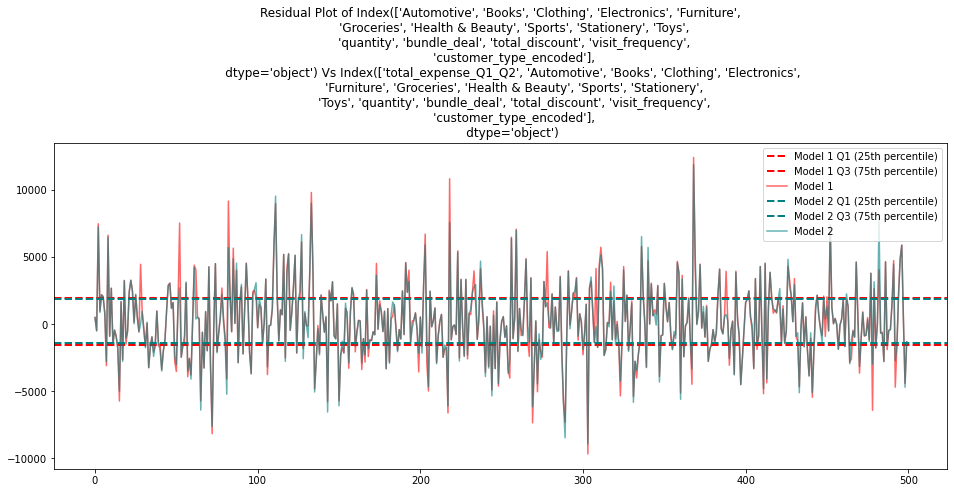

"Model 2 RandomForestRegressor(bootstrap=False, criterion='absolute_error',\n                      max_features='sqrt', max_leaf_nodes=10, n_jobs=-1,\n                      random_state=2202934) with ['total_expense_Q1_Q2', 'Automotive', 'Books', 'Clothing', 'Electronics', 'Furniture', 'Groceries', 'Health & Beauty', 'Sports', 'Stationery', 'Toys', 'quantity', 'bundle_deal', 'total_discount', 'visit_frequency', 'customer_type_encoded'] has the smallest IQR range."

In [87]:
model_comparer(final_dtr, rf_regressor, df_final_drop, df_final)

Random Forest has better accuracy and explainability,and provides insights into how customer spending in Q1-Q2 affects Q4 expected spending. Thus, RF is better than DTR.

Based on Residual Plot, its clear that RF has better performance due to noticably smaller residuals.

While explainability of model is 83%, an accuracy of 70% (100-MAPE) may not be compelling enough to convince the business to trust the model.

### Decision Tree Classifier:
To test if I can **push the accuracy** and explainability of the model further, I will build a DTC to identify potential high spending customers for Q4 based on their behavior in Q1-Q2. This model could be used classify low and high spending customers, so that targetted market and sales strategies could be employed on Q4 to increase customers' spending.

Identifying high spenders is useful for the business as the business can strategise on who they should target their marketing towards. It also helps the business know what types of customers are the most profitable and who to focus on.

References:
- https://qualaroo.com/blog/customer-segmentation-analysis-types-examples-methods/

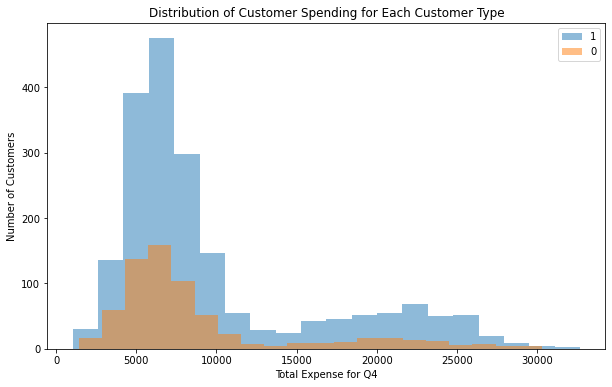

In [88]:
# Plotting the distribution of customer spending for each customer type
plt.figure(figsize=(10, 6))
for customer_type in df_final['customer_type_encoded'].unique():
    subset = df_final[df_final['customer_type_encoded'] == customer_type]
    plt.hist(subset['total_expense_2022Q4'], bins=20, alpha=0.5, label=customer_type)

plt.xlabel('Total Expense for Q4')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customer Spending for Each Customer Type')
plt.legend()
plt.show()

Based on visualisation, I will set the threshold of a high spender to be 15,000.

In [89]:
# identify high spenders
threshold = 15000
dtc_dataset = df_final_drop.copy() # retain og dataset for regression
dtc_dataset['high_spender'] = np.where(dtc_dataset['total_expense_2022Q4'] > threshold, 1, 0)

In [90]:
dtc_dataset.head()

,total_expense_2022Q4,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,quantity,bundle_deal,total_discount,visit_frequency,customer_type_encoded,high_spender
0,9901.78,4,3,3,5,0,30,2,3,2,5,258,10.0,904.30,47,1,0
1,5642.93,0,2,2,3,1,41,1,2,2,0,660,0.0,1081.24,54,1,0
2,4643.73,2,0,1,1,2,46,1,1,4,2,776,2.0,959.47,58,1,0
3,6567.15,6,0,4,3,2,21,4,1,4,2,233,6.0,668.44,41,1,0
4,9050.38,3,4,2,5,3,22,2,2,4,2,194,4.0,329.79,45,1,0


In [91]:
dtc_dataset.drop(columns=TARGET_COLUMN, inplace=True)

In [92]:
dtc_dataset.high_spender.value_counts()

0    2139
1     509
Name: high_spender, dtype: int64

In [93]:
from sklearn.tree import DecisionTreeClassifier

X_dtc = dtc_dataset.drop(['high_spender'], axis=1)  # predictors
y_dtc = dtc_dataset['high_spender']                 # target variable

# Split the data into training and testing sets
X_train_dtc, X_test_dtc, y_train_dtc, y_test_dtc = train_test_split(X_dtc, y_dtc, test_size=0.2, random_state=SEED)

# Create a Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=SEED)

# Define hyperparameters for GridSearch
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15]  # Adjust the depth based on your data and requirements
}

# Perform GridSearch to find the best hyperparameters
grid_search = GridSearchCV(dtc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_dtc, y_train_dtc)

# Get the best hyperparameters and create a pruned Decision Tree
best_params_dtc = grid_search.best_params_
dtc = DecisionTreeClassifier(**best_params_dtc, random_state=SEED)

# Fit the pruned model on the training data
dtc.fit(X_train_dtc, y_train_dtc)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=2202934)

### Check:

In [94]:
find_perm_importance(dtc, X_test_dtc, y_test_dtc)

Permutation Importances:

                  Feature  Importance Mean  Importance Std
13        visit_frequency         0.311132        0.016430
10               quantity         0.013836        0.002937
3             Electronics         0.000818        0.001161
12         total_discount         0.000314        0.000855
4               Furniture         0.000063        0.001333
0              Automotive         0.000000        0.000000
1                   Books         0.000000        0.000000
2                Clothing         0.000000        0.000000
6         Health & Beauty         0.000000        0.000000
8              Stationery         0.000000        0.000000
9                    Toys         0.000000        0.000000
14  customer_type_encoded         0.000000        0.000000
7                  Sports        -0.000063        0.001333
11            bundle_deal        -0.001195        0.001141
5               Groceries        -0.001572        0.000703


In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Print feature importances
feature_importances = list(zip(X.columns, dtc.feature_importances_))
feature_importances_df = pd.DataFrame(feature_importances, columns=['Feature', 'Importance'])
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df)

# Evaluate the model on the training set
print('\nTraining performance')
accuracy_train = accuracy_score(y_train_dtc, dtc.predict(X_train_dtc))
precision_train = precision_score(y_train_dtc, dtc.predict(X_train_dtc), pos_label=1)
recall_train = recall_score(y_train_dtc, dtc.predict(X_train_dtc), pos_label=1)

print(f"Accuracy: {accuracy_train}")
print(f"Precision for class 1: {precision_train}")
print(f"Recall for class 1: {recall_train}")

# Evaluate the model on the testing set
print('\nTesting performance')
accuracy_test = accuracy_score(y_test_dtc, dtc.predict(X_test_dtc))
precision_test = precision_score(y_test_dtc, dtc.predict(X_test_dtc), pos_label=1)
recall_test = recall_score(y_test_dtc, dtc.predict(X_test_dtc), pos_label=1)

print(f"Accuracy: {accuracy_test}")
print(f"Precision for class 1: {precision_test}")
print(f"Recall for class 1: {recall_test}")

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test_dtc, dtc.predict(X_test_dtc))
print("\nConfusion Matrix (Testing Set):\n", conf_matrix_test)

                Feature  Importance
13       total_discount    0.954688
10                 Toys    0.010113
12          bundle_deal    0.009959
11             quantity    0.006583
3              Clothing    0.006524
4           Electronics    0.006362
5             Furniture    0.003167
7       Health & Beauty    0.002604
0   total_expense_Q1_Q2    0.000000
1            Automotive    0.000000
2                 Books    0.000000
6             Groceries    0.000000
8                Sports    0.000000
9            Stationery    0.000000
14      visit_frequency    0.000000

Training performance
Accuracy: 0.9910292728989613
Precision for class 1: 0.9633251833740831
Recall for class 1: 0.9899497487437185

Testing performance
Accuracy: 0.9830188679245283
Precision for class 1: 0.9396551724137931
Recall for class 1: 0.9819819819819819

Confusion Matrix (Testing Set):
 [[412   7]
 [  2 109]]


Impressive performance from DTC as accuracy in predicting a high spending customer is 98%. The misclassification rate is insignificantly low, indicating that this model is robust with high accuracy in predicting a potential high spending customer for Q4.

This suggests that I can **use DTC for identifying and understanding key drivers of customer engagement** (what drives customers to become a high spender) since the accuracy of DTC is high enough for me to be certain and trust the model.

### Act:

### Selecting Model:
The business requirements is to understand customer engagement and their **financial impact** for Q4. DTC doesn't clearly answer 'financial impact' requirement as it only classifies if customer will be a high spender, hence it cannot be deployed despite an impressive accuracy of 98%.

However, DTC can be used to reliability understand customer's engagement and how it influences the likelihood for a customer to be a high spender in Q4 due to its high accuracy which can assure the business to trust the insights.

I will choose Final **DTR as the model to be deployed** since the added complexity of Random Forest doesn't lead to any noticable performance improvement, hence not worth the additional computational power required by RF.

## Interpreting 2 prospective models for deployment
using SHAP

In [96]:
import shap

### Interpreting DTC (For predicting high spending customers) 98% accuracy

In [97]:
# SHAP Analysis
shap.initjs()
explainer_dtc = shap.TreeExplainer(dtc)

# Calculate SHAP values
shap_values_dtc = explainer_dtc.shap_values(X_test_dtc)

In [98]:
class_index = 1    # interested in identifying high spending customers

# Interactive Force plot
shap.force_plot(explainer_dtc.expected_value[class_index], shap_values_dtc[class_index], X_test_dtc)

Key Takeaway:
- Visit_frequency is the most important factor to determine whether customers will be a high spender in Q4. Customers who are more loyal and shop at Retail Hypermarket regularly are 98% likely to spend above $15,000 in Q4.

Delving into the intricacies of how the features influence the likelihood for a customer to spend a lot during Q4, I will select certain unique samples and study them.

#### Qualities of high spender:
> 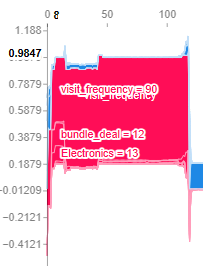

In [99]:
# Index of the instance you want to investigate
instance_index = 447

# Individual SHAP values for the specified instance and class
shap_values_instance_class = shap_values_dtc[class_index][instance_index, :]

# Feature values for the specified instance
instance_features = X_test_dtc.iloc[[instance_index]]

# Create the force plot
shap.force_plot(
    explainer_dtc.expected_value[class_index],
    shap_values_instance_class,
    instance_features
)

In [100]:
# Index of the instance you want to investigate
instance_index = 336

# Individual SHAP values for the specified instance and class
shap_values_instance_class = shap_values_dtc[class_index][instance_index, :]

# Feature values for the specified instance
instance_features = X_test_dtc.iloc[[instance_index]]

# Create the force plot
shap.force_plot(
    explainer_dtc.expected_value[class_index],
    shap_values_instance_class,
    instance_features
)

- engaged in over 10 electronic products or bundle deals
- shopped at Retail Hypermarket for around 90 days for Q1-Q2. 

#### What causes loyal customers to not be a high spender?
> 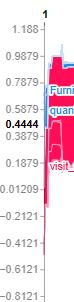

In [101]:
# Index of the instance you want to investigate
instance_index = 154

# Individual SHAP values for the specified instance and class
shap_values_instance_class = shap_values_dtc[class_index][instance_index, :]

# Feature values for the specified instance
instance_features = X_test_dtc.iloc[[instance_index]]

# Create the force plot
shap.force_plot(
    explainer_dtc.expected_value[class_index],
    shap_values_instance_class,
    instance_features
)

In [102]:
# Index of the instance you want to investigate
instance_index = 317

# Individual SHAP values for the specified instance and class
shap_values_instance_class = shap_values_dtc[class_index][instance_index, :]

# Feature values for the specified instance
instance_features = X_test_dtc.iloc[[instance_index]]

# Create the force plot
shap.force_plot(
    explainer_dtc.expected_value[class_index],
    shap_values_instance_class,
    instance_features
)

- buys less than 1,000 items in Q1-Q2.
- mostly spends on groceries which are cheaper than electronic products.

#### Qualities of average (low-spending) customer
> 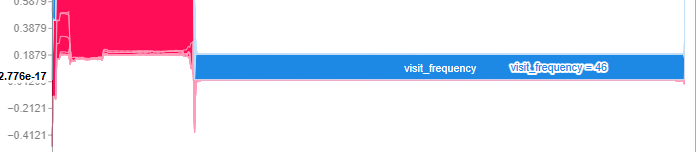

In [103]:
# Index of the instance you want to investigate
instance_index = 515

# Individual SHAP values for the specified instance and class
shap_values_instance_class = shap_values_dtc[class_index][instance_index, :]

# Feature values for the specified instance
instance_features = X_test_dtc.iloc[[instance_index]]

# Create the force plot
shap.force_plot(
    explainer_dtc.expected_value[class_index],
    shap_values_instance_class,
    instance_features
)

In [104]:
# Index of the instance you want to investigate
instance_index = 397

# Individual SHAP values for the specified instance and class
shap_values_instance_class = shap_values_dtc[class_index][instance_index, :]

# Feature values for the specified instance
instance_features = X_test_dtc.iloc[[instance_index]]

# Create the force plot
shap.force_plot(
    explainer_dtc.expected_value[class_index],
    shap_values_instance_class,
    instance_features
)

- don't shop at Retail Hypermarket often.

### Interpreting RF (For predicting customer spending in Q4) 70% accuracy

In [105]:
# check that X_train is the one with total_expense
X_train.head()

,total_expense_Q1_Q2,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,quantity,bundle_deal,total_discount,visit_frequency,customer_type_encoded
1171,14126.91,1,2,5,2,3,47,2,2,0,2,723,1.0,651.56,65,0
1653,13941.21,1,2,1,0,1,46,2,3,0,0,755,0.0,318.64,56,1
833,16434.02,0,6,3,1,5,20,4,5,4,5,276,8.0,1088.67,45,0
908,12915.85,1,0,2,1,1,46,1,2,2,4,761,1.0,306.43,59,0
79,13403.55,2,0,5,5,1,29,3,1,3,0,275,4.0,629.04,44,1


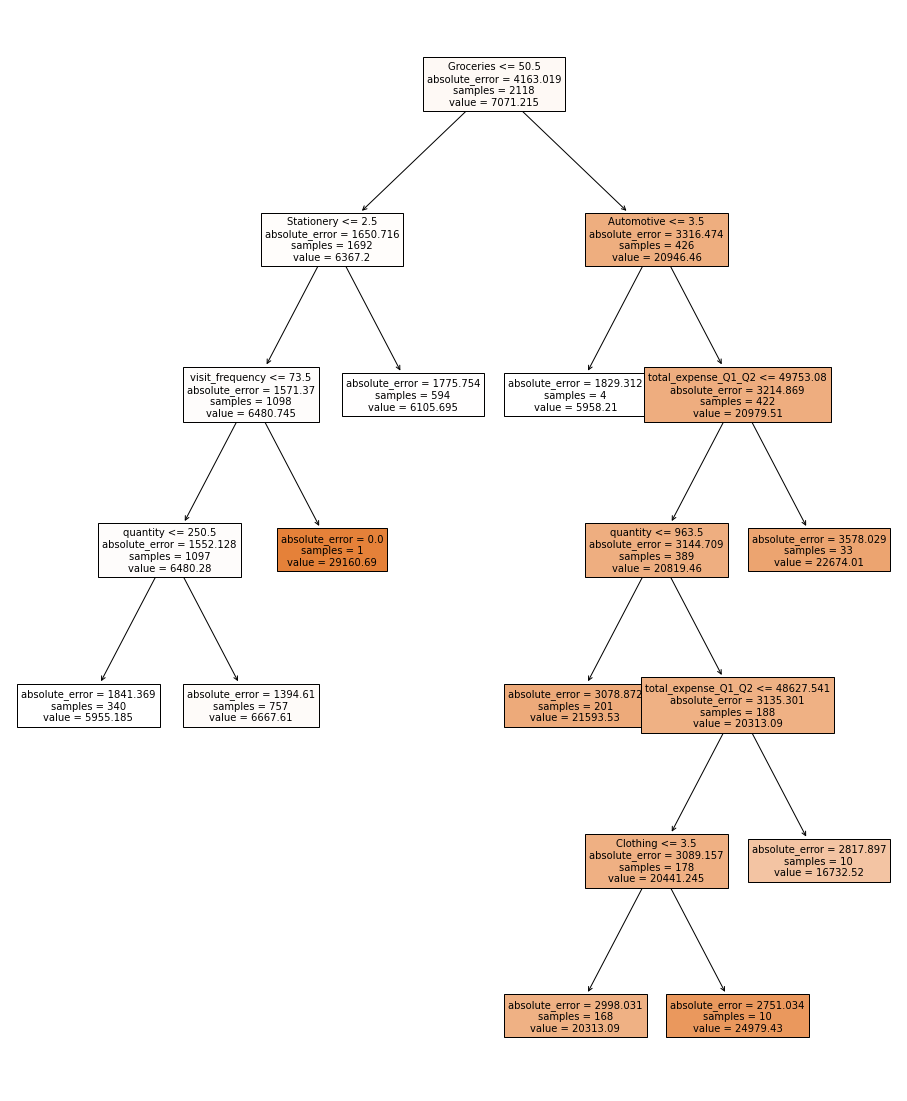

R-squared (Goodness of Fit): 0.84


In [106]:
understand_model(rf_regressor, X_train, y_train, X, training=True, tree_to_visualize=1)

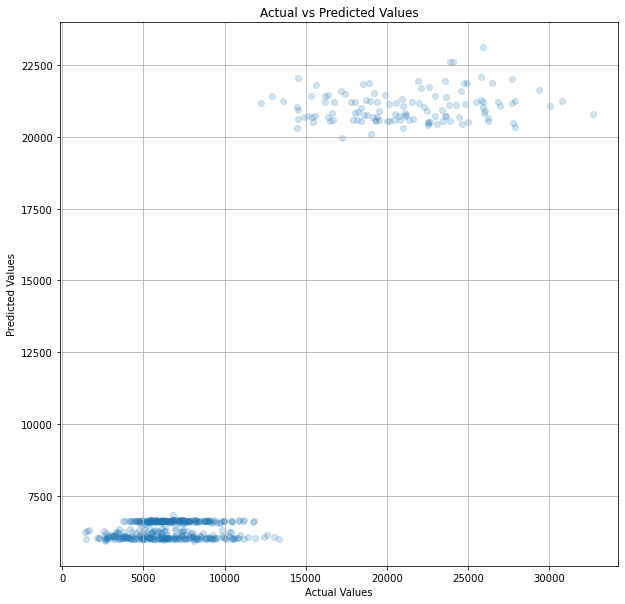

R-squared (Goodness of Fit): 0.83


In [107]:
understand_model(rf_regressor, X_test, y_test, X, training=False)

In [108]:
# SHAP Analysis
shap.initjs()
explainer_rf = shap.TreeExplainer(rf_regressor)

# Calculate SHAP values
shap_values_rf = explainer_rf.shap_values(X_test)

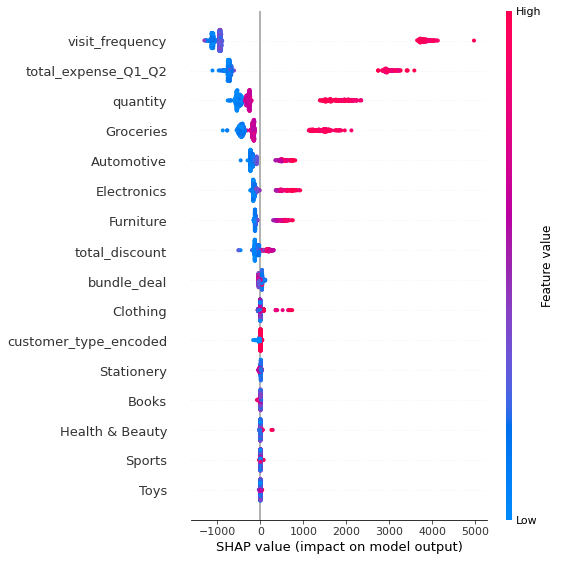

In [109]:
# summary plot
shap.summary_plot(shap_values_rf[:,:], features=X_test, feature_names=X_test.columns)

In [110]:
# Interactive Force plot to analyse features and select specific samples to analyze
shap.force_plot(explainer_rf.expected_value, shap_values_rf, X_test)

#### Analysis:
Visit frequency is the most significant factor that determines the customer spending for Q4. Loyal customers who visit and make a purchase for atleast 80 days during Q1-Q2 results in a high expected spending in Q4. (This insight was not revealed from DTC)

#### Model Evaluation:
> RF provides deeper (intricate relationships between factors) insights compared to DTC. Therefore **RF is better than DTC** even for interpreting customer engagement due to more insights hence increased usefulness for generating business strategies and decision-making.

#### Waterfall Plot
To evaluate the impact on predictors on the prediction (whether leads to drop or rise).

Inputs:
> index of rows to investigate, shap_values, shap explainer, predictors, actual values for target

In [111]:
def waterfall_plot(i, shap_values, explainer, X_test=X_test, y_test=y_test):

    # Create an Explanation object
    expected_value = explainer.expected_value
    explanation = shap.Explanation(values=shap_values[i], 
                                   base_values=expected_value, data=X_test.iloc[i, :])

    # Plot the waterfall plot
    print('Actual Expenditure: ', y_test.iloc[i])
    shap.plots.waterfall(explanation)

#### Qualities of low spender:
> 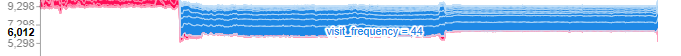

Actual Expenditure:  7688.15


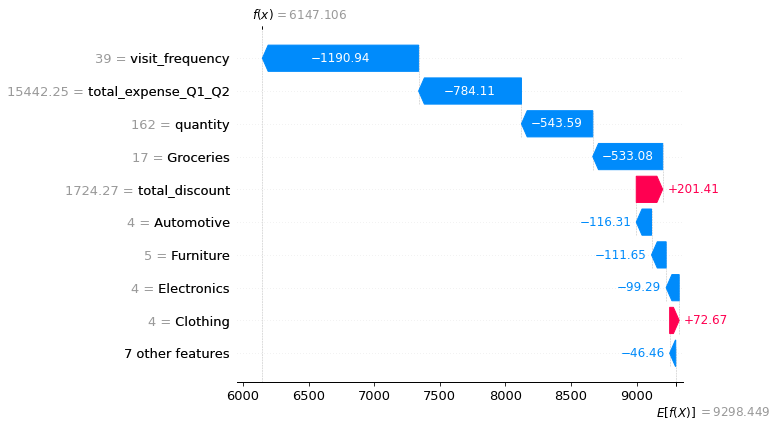

In [112]:
waterfall_plot(330, shap_values=shap_values_rf, explainer=explainer_rf)

Actual Expenditure:  4498.17


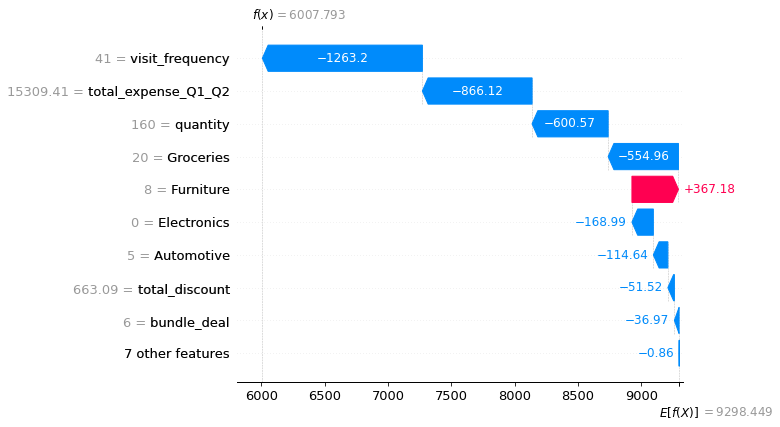

In [113]:
waterfall_plot(11, shap_values=shap_values_rf, explainer=explainer_rf)

- don't shop frequently, hence buy fewer items.
- low engagement in electronics (don't buy much electronic products).
- engagement in Furniture, discounts, and clothing increases spending expectency.

#### Qualitites of high spender:
> 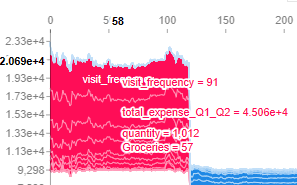

Actual Expenditure:  25485.56


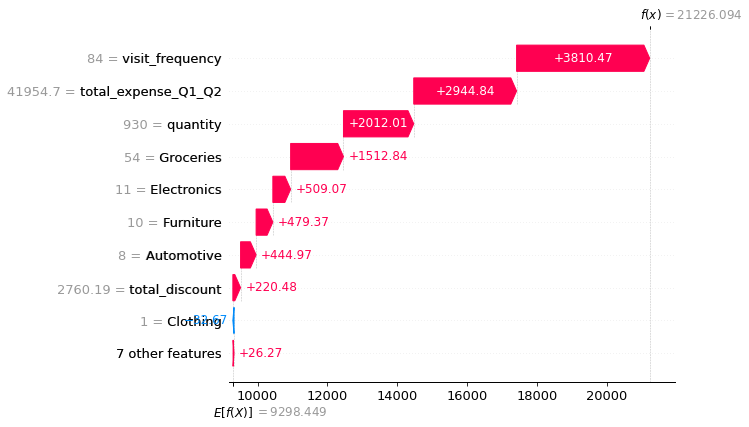

In [114]:
waterfall_plot(516, shap_values=shap_values_rf, explainer=explainer_rf)

Actual Expenditure:  24718.27


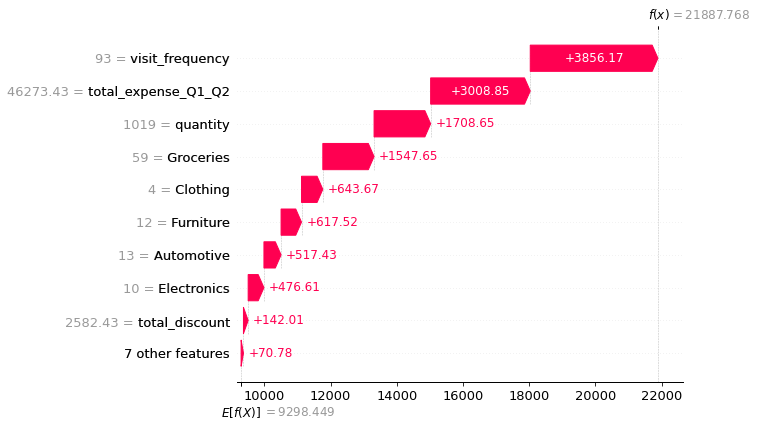

In [115]:
waterfall_plot(319, shap_values=shap_values_rf, explainer=explainer_rf)

- shop more frequently, buy more items, spend more money; loyal customers.
- high engagement in electronics, groceries, furniture, automotive, and clothing.

#### SHAP Dependence Plot Analysis
To investigate how interactions between factors affect potential customer spending.
- Find interesting insights.

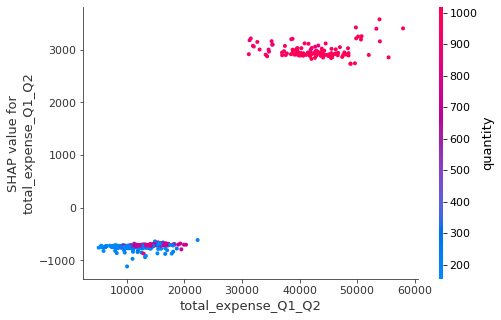

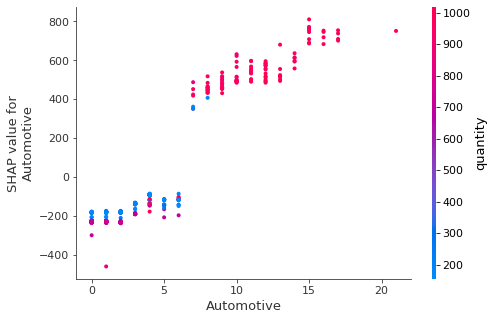

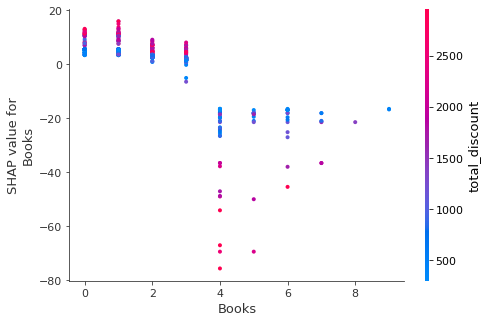

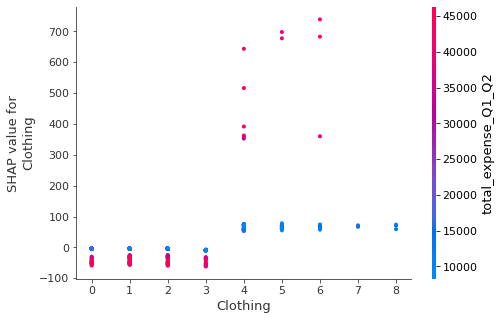

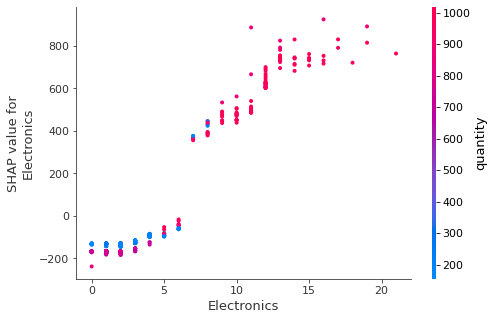

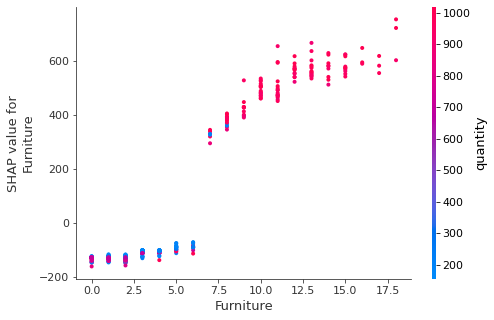

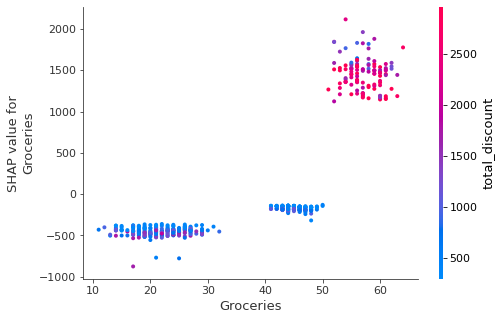

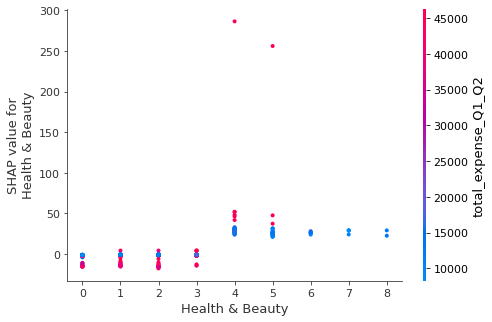

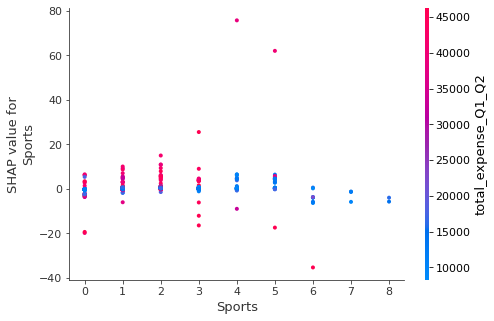

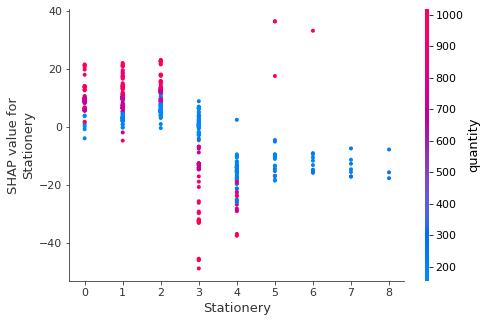

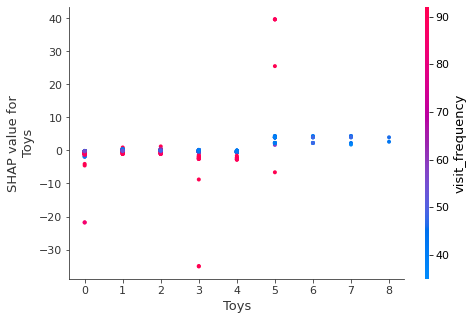

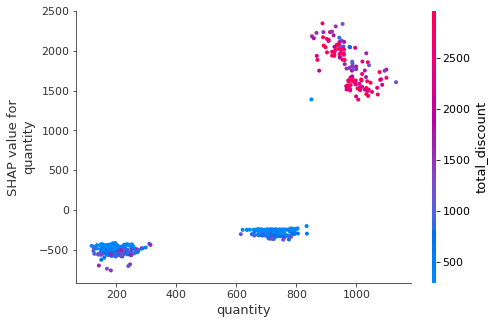

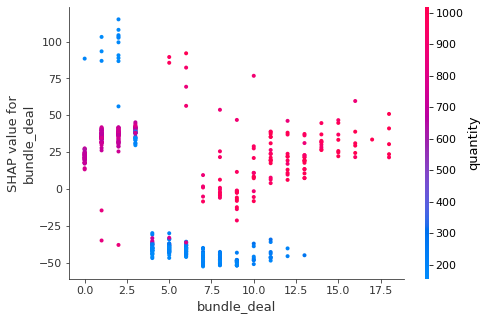

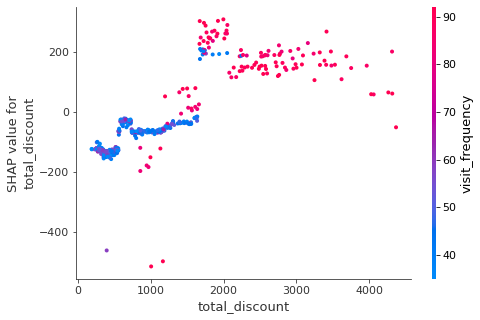

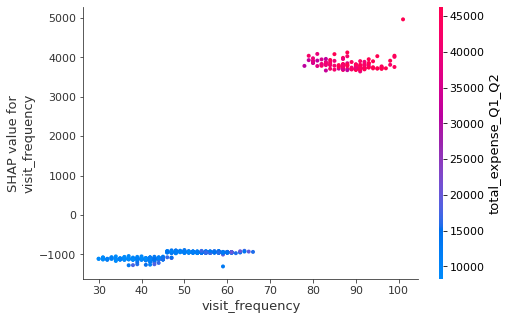

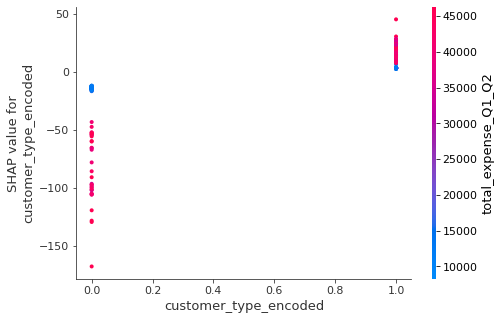

In [116]:
# Depenedence Plot
for feature_name in X_test.columns:
    # Calculate SHAP values for the current feature
    shap.dependence_plot(feature_name, shap_values_rf, X_test)

### Preparing Random Forest for Deployment

In [117]:
def predict_engagement(input_data): 
    # input_data = X DataFrame, let function know the columns used

    # Predict for an individual record
    input_record = {}  # Dictionary to store user input
    for column in input_data.columns:
        input_record[column] = float(input(f"Enter {column}: "))

    input_record_df = pd.DataFrame([input_record])
    prediction = rf_regressor.predict(input_record_df)
    print(f"Predicted Value: {prediction[0]}")

In [118]:
df_final.sample(random_state=SEED)

,total_expense_2022Q4,total_expense_Q1_Q2,Automotive,Books,Clothing,Electronics,Furniture,Groceries,Health & Beauty,Sports,Stationery,Toys,quantity,bundle_deal,total_discount,visit_frequency,customer_type_encoded
762,6478.45,8776.46,3,2,2,2,2,23,5,0,3,2,183,7.0,736.7,37,0


In [119]:
predict_engagement(X_train)

Enter total_expense_Q1_Q2: 8776.46
Enter Automotive: 3
Enter Books: 2
Enter Clothing: 2
Enter Electronics: 2
Enter Furniture: 2
Enter Groceries: 23
Enter Health & Beauty: 5
Enter Sports: 0
Enter Stationery: 3
Enter Toys: 2
Enter quantity: 183
Enter bundle_deal: 7
Enter total_discount: 736.7
Enter visit_frequency: 37
Enter customer_type_encoded: 0
Predicted Value: 6015.081750000003


### End of Project Part 2

#### References:
- scikit-learn: https://scikit-learn.org/stable/
- SHAPley library documentation: https://shap-lrjball.readthedocs.io/en/latest/index.html